In [277]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace




In [278]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [279]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [280]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [281]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [282]:
configs.specifier = specifier
configs.data_name = data_name



In [283]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [284]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [285]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,Grade_2,Sex_2,Grade_1,FIX_Y,Grade_6,Grade_5,FIX_X,IQ,Grade_3,Sex_1,Grade_4,FIX_DURATION,Age
0,0,0,0,531.8,0,0,177.3,23,0,1,1,219.0,10
1,0,0,0,545.2,0,0,200.5,23,0,1,1,247.0,10
2,0,0,0,542.4,0,0,282.7,23,0,1,1,261.0,10
3,0,0,0,545.5,0,0,358.1,23,0,1,1,268.0,10
4,0,0,0,536.3,0,0,392.8,23,0,1,1,129.0,10


In [13]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [14]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [15]:

data_name



'dd_fix_demo'

In [16]:
x_org

,Grade_2,Sex_2,Grade_1,FIX_Y,Grade_6,Grade_5,FIX_X,IQ,Grade_3,Sex_1,Grade_4,FIX_DURATION,Age
0,0,0,0,531.8,0,0,177.3,23,0,1,1,219.0,10
1,0,0,0,545.2,0,0,200.5,23,0,1,1,247.0,10
2,0,0,0,542.4,0,0,282.7,23,0,1,1,261.0,10
3,0,0,0,545.5,0,0,358.1,23,0,1,1,268.0,10
4,0,0,0,536.3,0,0,392.8,23,0,1,1,129.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0,1,0,562.7,0,0,743.3,32,1,0,0,160.0,10
512,0,1,0,555.8,0,0,772.5,32,1,0,0,193.0,10
513,0,1,0,561.9,0,0,941.7,32,1,0,0,219.0,10
514,0,1,0,548.8,0,0,831.8,32,1,0,0,144.0,10


In [17]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [18]:


features = dd.features
features




['Grade_2',
 'Sex_2',
 'Grade_1',
 'FIX_Y',
 'Grade_6',
 'Grade_5',
 'FIX_X',
 'IQ',
 'Grade_3',
 'Sex_1',
 'Grade_4',
 'FIX_DURATION',
 'Age']

In [19]:

# data = dd.get_stratified_train_test_splits(
#         x=x, y=y,
#         labels=y_org.Group.values,
#         to_shuffle=to_shuffle,
#         n_splits=10
#     )

# for k, v in data.items():
#     print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

## Load the tuned parameters

In [20]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [21]:


specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [22]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [23]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [257]:



# n_s = str(6)
# x_train = data[n_s]["x_train"]
# x_test = data[n_s]["x_test"]
# y_train = data[n_s]["y_train"]
# y_test = data[n_s]["y_test"]

# Using the entire set to train the model, cause we have independent test
idx = np.random.permutation(len(x))


x_train = x[idx, :]
y_train = y[idx]


In [258]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

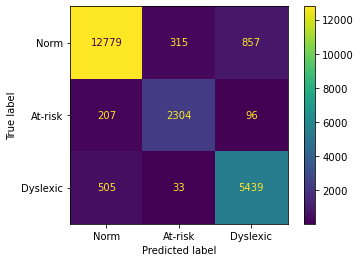

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


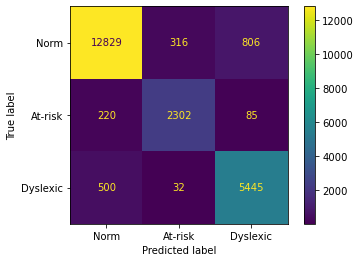

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


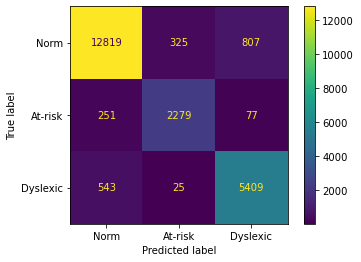

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


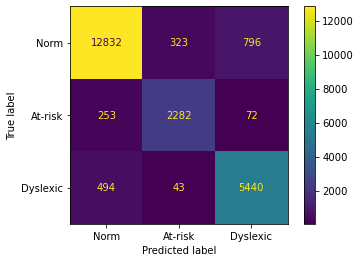

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


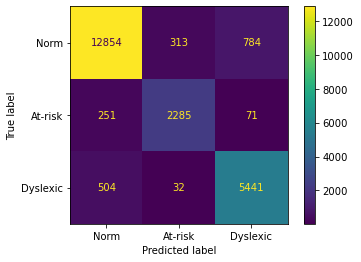

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


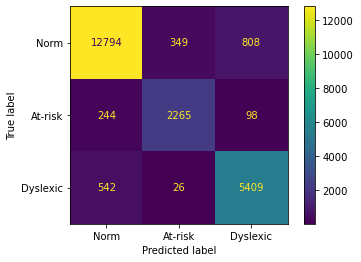

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


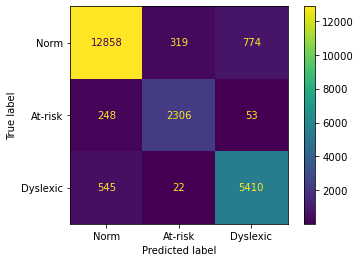

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


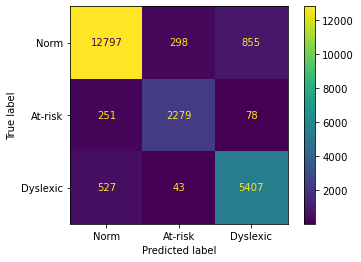

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


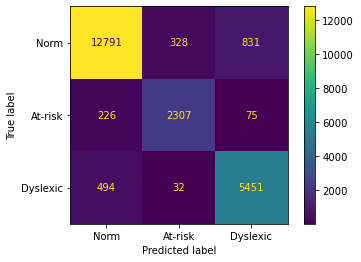

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


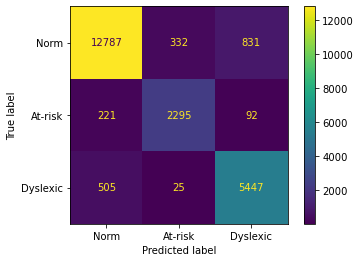

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [26]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [290]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.980 0.012 0.103 0.001 0.911 0.002 0.929 0.002


In [28]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2689     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07557D+00    |proj g|=  2.64104D-01


 This problem is unconstrained.



At iterate    1    f=  8.91402D-01    |proj g|=  4.01688D-02

At iterate    2    f=  8.77959D-01    |proj g|=  1.70590D-02

At iterate    3    f=  8.56049D-01    |proj g|=  3.71362D-02

At iterate    4    f=  8.35957D-01    |proj g|=  4.05915D-02

At iterate    5    f=  8.08942D-01    |proj g|=  4.70426D-03

At iterate    6    f=  8.06499D-01    |proj g|=  5.27147D-03

At iterate    7    f=  8.01687D-01    |proj g|=  6.42848D-03

At iterate    8    f=  7.96745D-01    |proj g|=  3.32640D-03

At iterate    9    f=  7.95318D-01    |proj g|=  1.51437D-02

At iterate   10    f=  7.92641D-01    |proj g|=  3.66148D-03

At iterate   11    f=  7.91961D-01    |proj g|=  1.64385D-03

At iterate   12    f=  7.90945D-01    |proj g|=  4.77525D-03

At iterate   13    f=  7.90518D-01    |proj g|=  7.43512D-03

At iterate   14    f=  7.89969D-01    |proj g|=  3.98039D-03

At iterate   15    f=  7.89049D-01    |proj g|=  1.66621D-03

At iterate   16    f=  7.87645D-01    |proj g|=  3.87836D-03

At iter


At iterate  134    f=  6.50707D-01    |proj g|=  4.76422D-03

At iterate  135    f=  6.48951D-01    |proj g|=  6.86292D-03

At iterate  136    f=  6.48366D-01    |proj g|=  1.14767D-02

At iterate  137    f=  6.47258D-01    |proj g|=  1.12604D-02

At iterate  138    f=  6.46564D-01    |proj g|=  9.61762D-03

At iterate  139    f=  6.46114D-01    |proj g|=  7.51332D-03

At iterate  140    f=  6.44813D-01    |proj g|=  6.93556D-03

At iterate  141    f=  6.43767D-01    |proj g|=  1.58660D-02

At iterate  142    f=  6.41564D-01    |proj g|=  1.62773D-02

At iterate  143    f=  6.39974D-01    |proj g|=  1.13572D-02

At iterate  144    f=  6.38632D-01    |proj g|=  2.08596D-02

At iterate  145    f=  6.37761D-01    |proj g|=  1.05443D-02

At iterate  146    f=  6.37187D-01    |proj g|=  9.69954D-03

At iterate  147    f=  6.35858D-01    |proj g|=  1.05513D-02

At iterate  148    f=  6.34705D-01    |proj g|=  1.42149D-02

At iterate  149    f=  6.33188D-01    |proj g|=  1.17618D-02

At iter


At iterate  267    f=  5.51144D-01    |proj g|=  4.27108D-03

At iterate  268    f=  5.50429D-01    |proj g|=  7.84547D-03

At iterate  269    f=  5.50302D-01    |proj g|=  1.16681D-02

At iterate  270    f=  5.49785D-01    |proj g|=  6.25488D-03

At iterate  271    f=  5.49621D-01    |proj g|=  5.50258D-03

At iterate  272    f=  5.49380D-01    |proj g|=  4.31021D-03

At iterate  273    f=  5.48734D-01    |proj g|=  6.14030D-03

At iterate  274    f=  5.48249D-01    |proj g|=  8.33889D-03

At iterate  275    f=  5.47430D-01    |proj g|=  1.16117D-02

At iterate  276    f=  5.46905D-01    |proj g|=  1.25842D-02

At iterate  277    f=  5.46448D-01    |proj g|=  6.75602D-03

At iterate  278    f=  5.46070D-01    |proj g|=  6.00306D-03

At iterate  279    f=  5.45654D-01    |proj g|=  3.74761D-03

At iterate  280    f=  5.45169D-01    |proj g|=  5.50283D-03

At iterate  281    f=  5.44696D-01    |proj g|=  8.85259D-03

At iterate  282    f=  5.44336D-01    |proj g|=  7.75855D-03

At iter


At iterate  400    f=  4.83639D-01    |proj g|=  6.93584D-03

At iterate  401    f=  4.83280D-01    |proj g|=  5.58987D-03

At iterate  402    f=  4.82586D-01    |proj g|=  9.68762D-03

At iterate  403    f=  4.81532D-01    |proj g|=  1.92676D-02

At iterate  404    f=  4.80364D-01    |proj g|=  7.02125D-03

At iterate  405    f=  4.79641D-01    |proj g|=  6.24158D-03

At iterate  406    f=  4.78675D-01    |proj g|=  1.64446D-02

At iterate  407    f=  4.78150D-01    |proj g|=  1.32740D-02

At iterate  408    f=  4.77385D-01    |proj g|=  6.11531D-03

At iterate  409    f=  4.76914D-01    |proj g|=  5.83239D-03

At iterate  410    f=  4.76156D-01    |proj g|=  6.68892D-03

At iterate  411    f=  4.74750D-01    |proj g|=  1.13694D-02

At iterate  412    f=  4.74173D-01    |proj g|=  1.93561D-02

At iterate  413    f=  4.73129D-01    |proj g|=  7.96472D-03

At iterate  414    f=  4.72736D-01    |proj g|=  5.65505D-03

At iterate  415    f=  4.72271D-01    |proj g|=  5.99688D-03

At iter


At iterate  670    f=  3.80580D-01    |proj g|=  6.85597D-03

At iterate  671    f=  3.80305D-01    |proj g|=  2.04831D-02

At iterate  672    f=  3.79878D-01    |proj g|=  5.21692D-03

At iterate  673    f=  3.79772D-01    |proj g|=  3.58736D-03

At iterate  674    f=  3.79629D-01    |proj g|=  4.73393D-03

At iterate  675    f=  3.79426D-01    |proj g|=  4.44322D-03

At iterate  676    f=  3.79323D-01    |proj g|=  1.03477D-02

At iterate  677    f=  3.79035D-01    |proj g|=  8.35339D-03

At iterate  678    f=  3.78688D-01    |proj g|=  6.77442D-03

At iterate  679    f=  3.78250D-01    |proj g|=  6.18462D-03

At iterate  680    f=  3.77870D-01    |proj g|=  1.02756D-02

At iterate  681    f=  3.77658D-01    |proj g|=  8.91057D-03

At iterate  682    f=  3.77404D-01    |proj g|=  5.03449D-03

At iterate  683    f=  3.77284D-01    |proj g|=  4.31339D-03

At iterate  684    f=  3.77185D-01    |proj g|=  3.87575D-03

At iterate  685    f=  3.77052D-01    |proj g|=  1.08137D-02

At iter


At iterate  803    f=  3.43613D-01    |proj g|=  8.63465D-03

At iterate  804    f=  3.43354D-01    |proj g|=  4.47253D-03

At iterate  805    f=  3.43185D-01    |proj g|=  5.13121D-03

At iterate  806    f=  3.42903D-01    |proj g|=  4.68328D-03

At iterate  807    f=  3.42788D-01    |proj g|=  6.80461D-03

At iterate  808    f=  3.42579D-01    |proj g|=  4.58749D-03

At iterate  809    f=  3.42331D-01    |proj g|=  4.27074D-03

At iterate  810    f=  3.41957D-01    |proj g|=  6.74431D-03

At iterate  811    f=  3.41831D-01    |proj g|=  1.10939D-02

At iterate  812    f=  3.41499D-01    |proj g|=  9.39986D-03

At iterate  813    f=  3.41235D-01    |proj g|=  6.29751D-03

At iterate  814    f=  3.40958D-01    |proj g|=  4.83932D-03

At iterate  815    f=  3.40692D-01    |proj g|=  5.99584D-03

At iterate  816    f=  3.40546D-01    |proj g|=  8.69647D-03

At iterate  817    f=  3.40296D-01    |proj g|=  6.76298D-03

At iterate  818    f=  3.40033D-01    |proj g|=  5.28199D-03

At iter


At iterate  936    f=  3.14720D-01    |proj g|=  7.42476D-03

At iterate  937    f=  3.14576D-01    |proj g|=  9.73350D-03

At iterate  938    f=  3.14437D-01    |proj g|=  6.46479D-03

At iterate  939    f=  3.14250D-01    |proj g|=  4.66624D-03

At iterate  940    f=  3.14133D-01    |proj g|=  6.90135D-03

At iterate  941    f=  3.14021D-01    |proj g|=  7.43130D-03

At iterate  942    f=  3.13866D-01    |proj g|=  4.68683D-03

At iterate  943    f=  3.13812D-01    |proj g|=  3.13060D-03

At iterate  944    f=  3.13669D-01    |proj g|=  4.09557D-03

At iterate  945    f=  3.13489D-01    |proj g|=  6.17874D-03

At iterate  946    f=  3.13292D-01    |proj g|=  1.47068D-02

At iterate  947    f=  3.13007D-01    |proj g|=  8.10873D-03

At iterate  948    f=  3.12851D-01    |proj g|=  4.05408D-03

At iterate  949    f=  3.12672D-01    |proj g|=  4.76454D-03

At iterate  950    f=  3.12481D-01    |proj g|=  1.73929D-02

At iterate  951    f=  3.12262D-01    |proj g|=  1.08358D-02

At iter


At iterate 1069    f=  2.91822D-01    |proj g|=  4.98436D-03

At iterate 1070    f=  2.91718D-01    |proj g|=  3.49370D-03

At iterate 1071    f=  2.91577D-01    |proj g|=  6.23709D-03

At iterate 1072    f=  2.91315D-01    |proj g|=  8.53402D-03

At iterate 1073    f=  2.91016D-01    |proj g|=  6.85005D-03

At iterate 1074    f=  2.90829D-01    |proj g|=  9.66264D-03

At iterate 1075    f=  2.90604D-01    |proj g|=  7.96705D-03

At iterate 1076    f=  2.90485D-01    |proj g|=  8.52895D-03

At iterate 1077    f=  2.90333D-01    |proj g|=  1.14465D-02

At iterate 1078    f=  2.90154D-01    |proj g|=  6.07052D-03

At iterate 1079    f=  2.90011D-01    |proj g|=  4.23964D-03

At iterate 1080    f=  2.89814D-01    |proj g|=  7.30004D-03

At iterate 1081    f=  2.89708D-01    |proj g|=  6.42746D-03

At iterate 1082    f=  2.89574D-01    |proj g|=  5.07184D-03

At iterate 1083    f=  2.89380D-01    |proj g|=  3.15987D-03

At iterate 1084    f=  2.89208D-01    |proj g|=  4.92942D-03

At iter


At iterate 1202    f=  2.77688D-01    |proj g|=  9.09726D-03

At iterate 1203    f=  2.77590D-01    |proj g|=  2.60768D-03

At iterate 1204    f=  2.77552D-01    |proj g|=  2.96009D-03

At iterate 1205    f=  2.77501D-01    |proj g|=  5.50780D-03

At iterate 1206    f=  2.77416D-01    |proj g|=  4.58422D-03

At iterate 1207    f=  2.77290D-01    |proj g|=  4.39613D-03

At iterate 1208    f=  2.77130D-01    |proj g|=  5.44868D-03

At iterate 1209    f=  2.77029D-01    |proj g|=  4.44364D-03

At iterate 1210    f=  2.76928D-01    |proj g|=  3.85890D-03

At iterate 1211    f=  2.76907D-01    |proj g|=  1.45882D-02

At iterate 1212    f=  2.76810D-01    |proj g|=  3.61594D-03

At iterate 1213    f=  2.76765D-01    |proj g|=  2.58813D-03

At iterate 1214    f=  2.76709D-01    |proj g|=  3.79580D-03

At iterate 1215    f=  2.76621D-01    |proj g|=  4.70133D-03

At iterate 1216    f=  2.76528D-01    |proj g|=  7.92138D-03

At iterate 1217    f=  2.76405D-01    |proj g|=  3.84504D-03

At iter


At iterate 1335    f=  2.65843D-01    |proj g|=  3.55499D-03

At iterate 1336    f=  2.65655D-01    |proj g|=  4.46150D-03

At iterate 1337    f=  2.65515D-01    |proj g|=  1.09976D-02

At iterate 1338    f=  2.65358D-01    |proj g|=  6.07434D-03

At iterate 1339    f=  2.65225D-01    |proj g|=  6.32890D-03

At iterate 1340    f=  2.65165D-01    |proj g|=  1.34392D-02

At iterate 1341    f=  2.65010D-01    |proj g|=  8.28235D-03

At iterate 1342    f=  2.64903D-01    |proj g|=  3.57838D-03

At iterate 1343    f=  2.64833D-01    |proj g|=  4.44620D-03

At iterate 1344    f=  2.64734D-01    |proj g|=  4.48322D-03

At iterate 1345    f=  2.64648D-01    |proj g|=  9.68159D-03

At iterate 1346    f=  2.64544D-01    |proj g|=  3.76358D-03

At iterate 1347    f=  2.64491D-01    |proj g|=  6.73653D-03

At iterate 1348    f=  2.64425D-01    |proj g|=  3.58757D-03

At iterate 1349    f=  2.64333D-01    |proj g|=  3.99400D-03

At iterate 1350    f=  2.64202D-01    |proj g|=  5.80881D-03

At iter


At iterate 1468    f=  2.50962D-01    |proj g|=  7.16622D-03

At iterate 1469    f=  2.50905D-01    |proj g|=  4.57175D-03

At iterate 1470    f=  2.50836D-01    |proj g|=  3.51842D-03

At iterate 1471    f=  2.50762D-01    |proj g|=  3.72025D-03

At iterate 1472    f=  2.50597D-01    |proj g|=  5.54699D-03

At iterate 1473    f=  2.50533D-01    |proj g|=  1.03731D-02

At iterate 1474    f=  2.50393D-01    |proj g|=  6.07910D-03

At iterate 1475    f=  2.50271D-01    |proj g|=  3.34396D-03

At iterate 1476    f=  2.50152D-01    |proj g|=  6.87195D-03

At iterate 1477    f=  2.50020D-01    |proj g|=  5.23255D-03

At iterate 1478    f=  2.49935D-01    |proj g|=  9.63101D-03

At iterate 1479    f=  2.49816D-01    |proj g|=  6.52054D-03

At iterate 1480    f=  2.49657D-01    |proj g|=  5.01687D-03

At iterate 1481    f=  2.49551D-01    |proj g|=  5.28330D-03

At iterate 1482    f=  2.49462D-01    |proj g|=  1.51494D-02

At iterate 1483    f=  2.49299D-01    |proj g|=  3.64540D-03

At iter


At iterate 1601    f=  2.36586D-01    |proj g|=  8.52276D-03

At iterate 1602    f=  2.36453D-01    |proj g|=  7.81112D-03

At iterate 1603    f=  2.36353D-01    |proj g|=  4.71969D-03

At iterate 1604    f=  2.36149D-01    |proj g|=  5.01522D-03

At iterate 1605    f=  2.36006D-01    |proj g|=  9.55315D-03

At iterate 1606    f=  2.35846D-01    |proj g|=  8.31217D-03

At iterate 1607    f=  2.35709D-01    |proj g|=  5.67659D-03

At iterate 1608    f=  2.35627D-01    |proj g|=  7.12346D-03

At iterate 1609    f=  2.35556D-01    |proj g|=  4.49034D-03

At iterate 1610    f=  2.35450D-01    |proj g|=  7.32599D-03

At iterate 1611    f=  2.35316D-01    |proj g|=  7.42873D-03

At iterate 1612    f=  2.35247D-01    |proj g|=  5.52467D-03

At iterate 1613    f=  2.35100D-01    |proj g|=  4.15182D-03

At iterate 1614    f=  2.34950D-01    |proj g|=  9.70436D-03

At iterate 1615    f=  2.34782D-01    |proj g|=  5.73886D-03

At iterate 1616    f=  2.34645D-01    |proj g|=  5.04346D-03

At iter


At iterate 1734    f=  2.23030D-01    |proj g|=  8.92274D-03

At iterate 1735    f=  2.22949D-01    |proj g|=  3.97258D-03

At iterate 1736    f=  2.22794D-01    |proj g|=  5.69188D-03

At iterate 1737    f=  2.22692D-01    |proj g|=  7.06908D-03

At iterate 1738    f=  2.22665D-01    |proj g|=  1.95966D-02

At iterate 1739    f=  2.22470D-01    |proj g|=  4.63380D-03

At iterate 1740    f=  2.22430D-01    |proj g|=  3.04151D-03

At iterate 1741    f=  2.22387D-01    |proj g|=  1.16963D-02

At iterate 1742    f=  2.22336D-01    |proj g|=  5.84928D-03

At iterate 1743    f=  2.22265D-01    |proj g|=  4.91358D-03

At iterate 1744    f=  2.22199D-01    |proj g|=  6.41887D-03

At iterate 1745    f=  2.22079D-01    |proj g|=  5.98786D-03

At iterate 1746    f=  2.21969D-01    |proj g|=  8.09990D-03

At iterate 1747    f=  2.21857D-01    |proj g|=  3.36576D-03

At iterate 1748    f=  2.21783D-01    |proj g|=  4.67053D-03

At iterate 1749    f=  2.21697D-01    |proj g|=  1.29056D-02

At iter


At iterate 1867    f=  2.12109D-01    |proj g|=  3.08832D-03

At iterate 1868    f=  2.12086D-01    |proj g|=  3.20199D-03

At iterate 1869    f=  2.12001D-01    |proj g|=  3.84591D-03

At iterate 1870    f=  2.11957D-01    |proj g|=  6.20624D-03

At iterate 1871    f=  2.11865D-01    |proj g|=  3.46744D-03

At iterate 1872    f=  2.11789D-01    |proj g|=  4.70620D-03

At iterate 1873    f=  2.11723D-01    |proj g|=  6.33910D-03

At iterate 1874    f=  2.11660D-01    |proj g|=  4.20264D-03

At iterate 1875    f=  2.11631D-01    |proj g|=  2.81617D-03

At iterate 1876    f=  2.11566D-01    |proj g|=  2.54092D-03

At iterate 1877    f=  2.11496D-01    |proj g|=  3.21473D-03

At iterate 1878    f=  2.11462D-01    |proj g|=  1.28443D-02

At iterate 1879    f=  2.11402D-01    |proj g|=  5.93578D-03

At iterate 1880    f=  2.11342D-01    |proj g|=  3.38689D-03

At iterate 1881    f=  2.11282D-01    |proj g|=  4.39203D-03

At iterate 1882    f=  2.11184D-01    |proj g|=  4.37982D-03

At iter


At iterate 2000    f=  2.06138D-01    |proj g|=  5.16795D-03

At iterate 2001    f=  2.06108D-01    |proj g|=  1.05752D-02

At iterate 2002    f=  2.06054D-01    |proj g|=  3.06906D-03

At iterate 2003    f=  2.06029D-01    |proj g|=  2.31739D-03

At iterate 2004    f=  2.05989D-01    |proj g|=  2.61872D-03

At iterate 2005    f=  2.05939D-01    |proj g|=  2.18375D-03

At iterate 2006    f=  2.05915D-01    |proj g|=  4.86801D-03

At iterate 2007    f=  2.05878D-01    |proj g|=  1.96694D-03

At iterate 2008    f=  2.05858D-01    |proj g|=  1.98585D-03

At iterate 2009    f=  2.05821D-01    |proj g|=  1.85632D-03

At iterate 2010    f=  2.05786D-01    |proj g|=  7.50298D-03

At iterate 2011    f=  2.05743D-01    |proj g|=  4.99058D-03

At iterate 2012    f=  2.05699D-01    |proj g|=  2.07830D-03

At iterate 2013    f=  2.05657D-01    |proj g|=  7.62418D-03

At iterate 2014    f=  2.05613D-01    |proj g|=  4.90517D-03

At iterate 2015    f=  2.05573D-01    |proj g|=  3.30100D-03

At iter


At iterate 2133    f=  2.01914D-01    |proj g|=  2.62077D-03

At iterate 2134    f=  2.01878D-01    |proj g|=  2.69718D-03

At iterate 2135    f=  2.01864D-01    |proj g|=  2.33570D-03

At iterate 2136    f=  2.01846D-01    |proj g|=  7.08279D-03

At iterate 2137    f=  2.01809D-01    |proj g|=  2.33995D-03

At iterate 2138    f=  2.01796D-01    |proj g|=  2.19663D-03

At iterate 2139    f=  2.01762D-01    |proj g|=  1.96228D-03

At iterate 2140    f=  2.01721D-01    |proj g|=  2.36092D-03

At iterate 2141    f=  2.01708D-01    |proj g|=  3.86793D-03

At iterate 2142    f=  2.01686D-01    |proj g|=  1.89472D-03

At iterate 2143    f=  2.01670D-01    |proj g|=  1.84638D-03

At iterate 2144    f=  2.01652D-01    |proj g|=  4.98221D-03

At iterate 2145    f=  2.01642D-01    |proj g|=  5.45073D-03

At iterate 2146    f=  2.01628D-01    |proj g|=  2.99215D-03

At iterate 2147    f=  2.01615D-01    |proj g|=  2.04029D-03

At iterate 2148    f=  2.01605D-01    |proj g|=  2.90450D-03

At iter


At iterate 2266    f=  1.99400D-01    |proj g|=  6.03781D-03

At iterate 2267    f=  1.99376D-01    |proj g|=  2.38673D-03

At iterate 2268    f=  1.99363D-01    |proj g|=  1.39871D-03

At iterate 2269    f=  1.99347D-01    |proj g|=  2.74220D-03

At iterate 2270    f=  1.99329D-01    |proj g|=  2.35744D-03

At iterate 2271    f=  1.99302D-01    |proj g|=  2.28990D-03

At iterate 2272    f=  1.99284D-01    |proj g|=  1.23995D-02

At iterate 2273    f=  1.99251D-01    |proj g|=  3.55044D-03

At iterate 2274    f=  1.99239D-01    |proj g|=  1.49064D-03

At iterate 2275    f=  1.99227D-01    |proj g|=  2.68997D-03

At iterate 2276    f=  1.99208D-01    |proj g|=  2.82707D-03

At iterate 2277    f=  1.99171D-01    |proj g|=  2.43937D-03

At iterate 2278    f=  1.99149D-01    |proj g|=  5.44232D-03

At iterate 2279    f=  1.99117D-01    |proj g|=  2.47604D-03

At iterate 2280    f=  1.99100D-01    |proj g|=  2.76248D-03

At iterate 2281    f=  1.99089D-01    |proj g|=  1.62116D-03

At iter


At iterate 2399    f=  1.97293D-01    |proj g|=  1.22332D-03

At iterate 2400    f=  1.97282D-01    |proj g|=  1.99574D-03

At iterate 2401    f=  1.97269D-01    |proj g|=  2.37694D-03

At iterate 2402    f=  1.97259D-01    |proj g|=  5.69614D-03

At iterate 2403    f=  1.97243D-01    |proj g|=  2.46024D-03

At iterate 2404    f=  1.97236D-01    |proj g|=  9.44391D-04

At iterate 2405    f=  1.97228D-01    |proj g|=  1.36434D-03

At iterate 2406    f=  1.97223D-01    |proj g|=  4.71813D-03

At iterate 2407    f=  1.97215D-01    |proj g|=  3.45458D-03

At iterate 2408    f=  1.97200D-01    |proj g|=  1.11927D-03

At iterate 2409    f=  1.97194D-01    |proj g|=  1.42744D-03

At iterate 2410    f=  1.97182D-01    |proj g|=  2.14067D-03

At iterate 2411    f=  1.97176D-01    |proj g|=  3.73139D-03

At iterate 2412    f=  1.97165D-01    |proj g|=  2.77105D-03

At iterate 2413    f=  1.97151D-01    |proj g|=  1.45018D-03

At iterate 2414    f=  1.97144D-01    |proj g|=  1.38907D-03

At iter


At iterate 2532    f=  1.96246D-01    |proj g|=  4.60083D-03

At iterate 2533    f=  1.96237D-01    |proj g|=  1.19216D-03

At iterate 2534    f=  1.96233D-01    |proj g|=  8.86546D-04

At iterate 2535    f=  1.96226D-01    |proj g|=  1.75937D-03

At iterate 2536    f=  1.96216D-01    |proj g|=  9.71402D-04

At iterate 2537    f=  1.96210D-01    |proj g|=  4.10456D-03

At iterate 2538    f=  1.96201D-01    |proj g|=  1.36415D-03

At iterate 2539    f=  1.96195D-01    |proj g|=  1.03605D-03

At iterate 2540    f=  1.96192D-01    |proj g|=  4.56386D-03

At iterate 2541    f=  1.96187D-01    |proj g|=  2.29205D-03

At iterate 2542    f=  1.96177D-01    |proj g|=  1.31233D-03

At iterate 2543    f=  1.96171D-01    |proj g|=  1.96005D-03

At iterate 2544    f=  1.96161D-01    |proj g|=  2.26231D-03

At iterate 2545    f=  1.96160D-01    |proj g|=  3.30464D-03

At iterate 2546    f=  1.96150D-01    |proj g|=  1.09331D-03

At iterate 2547    f=  1.96148D-01    |proj g|=  7.93959D-04

At iter


At iterate 2665    f=  1.95516D-01    |proj g|=  1.12397D-03

At iterate 2666    f=  1.95507D-01    |proj g|=  1.50639D-03

At iterate 2667    f=  1.95498D-01    |proj g|=  4.10978D-03

At iterate 2668    f=  1.95492D-01    |proj g|=  2.87093D-03

At iterate 2669    f=  1.95487D-01    |proj g|=  1.39199D-03

At iterate 2670    f=  1.95478D-01    |proj g|=  2.20638D-03

At iterate 2671    f=  1.95468D-01    |proj g|=  2.51389D-03

At iterate 2672    f=  1.95460D-01    |proj g|=  8.22339D-03

At iterate 2673    f=  1.95446D-01    |proj g|=  4.61191D-03

At iterate 2674    f=  1.95437D-01    |proj g|=  1.09910D-03

At iterate 2675    f=  1.95430D-01    |proj g|=  1.28683D-03

At iterate 2676    f=  1.95421D-01    |proj g|=  2.00849D-03

At iterate 2677    f=  1.95415D-01    |proj g|=  2.77937D-03

At iterate 2678    f=  1.95406D-01    |proj g|=  1.50397D-03

At iterate 2679    f=  1.95400D-01    |proj g|=  9.01558D-04

At iterate 2680    f=  1.95394D-01    |proj g|=  1.99029D-03

At iter


At iterate 2798    f=  1.94549D-01    |proj g|=  1.65572D-03

At iterate 2799    f=  1.94538D-01    |proj g|=  1.47312D-03

At iterate 2800    f=  1.94534D-01    |proj g|=  1.58244D-03

At iterate 2801    f=  1.94529D-01    |proj g|=  9.91897D-04

At iterate 2802    f=  1.94524D-01    |proj g|=  1.32927D-03

At iterate 2803    f=  1.94517D-01    |proj g|=  2.95896D-03

At iterate 2804    f=  1.94513D-01    |proj g|=  2.72091D-03

At iterate 2805    f=  1.94508D-01    |proj g|=  1.09656D-03

At iterate 2806    f=  1.94504D-01    |proj g|=  1.59664D-03

At iterate 2807    f=  1.94497D-01    |proj g|=  2.50019D-03

At iterate 2808    f=  1.94487D-01    |proj g|=  2.55116D-03

At iterate 2809    f=  1.94477D-01    |proj g|=  3.06287D-03

At iterate 2810    f=  1.94469D-01    |proj g|=  1.28240D-03

At iterate 2811    f=  1.94463D-01    |proj g|=  1.31448D-03

At iterate 2812    f=  1.94459D-01    |proj g|=  1.50977D-03

At iterate 2813    f=  1.94450D-01    |proj g|=  2.12587D-03

At iter


At iterate 2931    f=  1.93635D-01    |proj g|=  1.12027D-03

At iterate 2932    f=  1.93628D-01    |proj g|=  1.29874D-03

At iterate 2933    f=  1.93613D-01    |proj g|=  5.01425D-03

At iterate 2934    f=  1.93602D-01    |proj g|=  3.79635D-03

At iterate 2935    f=  1.93589D-01    |proj g|=  1.21253D-03

At iterate 2936    f=  1.93582D-01    |proj g|=  1.51742D-03

At iterate 2937    f=  1.93577D-01    |proj g|=  1.30403D-03

At iterate 2938    f=  1.93566D-01    |proj g|=  3.52033D-03

At iterate 2939    f=  1.93563D-01    |proj g|=  4.72392D-03

At iterate 2940    f=  1.93557D-01    |proj g|=  8.71570D-04

At iterate 2941    f=  1.93554D-01    |proj g|=  7.50552D-04

At iterate 2942    f=  1.93550D-01    |proj g|=  1.37489D-03

At iterate 2943    f=  1.93543D-01    |proj g|=  2.40627D-03

At iterate 2944    f=  1.93540D-01    |proj g|=  2.63091D-03

At iterate 2945    f=  1.93535D-01    |proj g|=  9.61577D-04

At iterate 2946    f=  1.93531D-01    |proj g|=  7.25356D-04

At iter


At iterate 3064    f=  1.92822D-01    |proj g|=  2.79204D-03

At iterate 3065    f=  1.92817D-01    |proj g|=  1.18512D-03

At iterate 3066    f=  1.92815D-01    |proj g|=  9.24972D-04

At iterate 3067    f=  1.92809D-01    |proj g|=  2.02295D-03

At iterate 3068    f=  1.92806D-01    |proj g|=  3.05495D-03

At iterate 3069    f=  1.92801D-01    |proj g|=  1.13507D-03

At iterate 3070    f=  1.92798D-01    |proj g|=  1.24753D-03

At iterate 3071    f=  1.92795D-01    |proj g|=  1.75484D-03

At iterate 3072    f=  1.92789D-01    |proj g|=  1.64571D-03

At iterate 3073    f=  1.92780D-01    |proj g|=  1.38840D-03

At iterate 3074    f=  1.92776D-01    |proj g|=  1.84259D-03

At iterate 3075    f=  1.92769D-01    |proj g|=  9.18793D-04

At iterate 3076    f=  1.92763D-01    |proj g|=  1.18164D-03

At iterate 3077    f=  1.92757D-01    |proj g|=  1.97367D-03

At iterate 3078    f=  1.92751D-01    |proj g|=  2.95320D-03

At iterate 3079    f=  1.92744D-01    |proj g|=  1.27945D-03

At iter


At iterate 3197    f=  1.92194D-01    |proj g|=  2.10818D-03

At iterate 3198    f=  1.92191D-01    |proj g|=  2.89154D-03

At iterate 3199    f=  1.92187D-01    |proj g|=  1.27880D-03

At iterate 3200    f=  1.92185D-01    |proj g|=  7.45782D-04

At iterate 3201    f=  1.92183D-01    |proj g|=  8.93640D-04

At iterate 3202    f=  1.92179D-01    |proj g|=  1.48993D-03

At iterate 3203    f=  1.92178D-01    |proj g|=  3.05675D-03

At iterate 3204    f=  1.92173D-01    |proj g|=  8.37709D-04

At iterate 3205    f=  1.92170D-01    |proj g|=  7.38332D-04

At iterate 3206    f=  1.92166D-01    |proj g|=  1.57697D-03

At iterate 3207    f=  1.92165D-01    |proj g|=  5.70090D-03

At iterate 3208    f=  1.92160D-01    |proj g|=  1.55907D-03

At iterate 3209    f=  1.92158D-01    |proj g|=  7.35255D-04

At iterate 3210    f=  1.92156D-01    |proj g|=  8.58113D-04

At iterate 3211    f=  1.92153D-01    |proj g|=  8.71357D-04

At iterate 3212    f=  1.92152D-01    |proj g|=  1.78600D-03

At iter


At iterate 3330    f=  1.91751D-01    |proj g|=  6.08684D-04

At iterate 3331    f=  1.91748D-01    |proj g|=  1.57924D-03

At iterate 3332    f=  1.91745D-01    |proj g|=  1.85135D-03

At iterate 3333    f=  1.91741D-01    |proj g|=  8.29536D-04

At iterate 3334    f=  1.91738D-01    |proj g|=  1.21793D-03

At iterate 3335    f=  1.91732D-01    |proj g|=  1.84398D-03

At iterate 3336    f=  1.91724D-01    |proj g|=  1.04136D-03

At iterate 3337    f=  1.91720D-01    |proj g|=  2.71559D-03

At iterate 3338    f=  1.91711D-01    |proj g|=  1.64402D-03

At iterate 3339    f=  1.91708D-01    |proj g|=  1.08682D-03

At iterate 3340    f=  1.91703D-01    |proj g|=  1.18388D-03

At iterate 3341    f=  1.91696D-01    |proj g|=  2.51594D-03

At iterate 3342    f=  1.91691D-01    |proj g|=  1.92784D-03

At iterate 3343    f=  1.91687D-01    |proj g|=  7.63957D-04

At iterate 3344    f=  1.91686D-01    |proj g|=  5.06651D-04

At iterate 3345    f=  1.91682D-01    |proj g|=  2.12381D-03

At iter


At iterate 3463    f=  1.91174D-01    |proj g|=  1.13296D-03

At iterate 3464    f=  1.91171D-01    |proj g|=  7.63614D-04

At iterate 3465    f=  1.91167D-01    |proj g|=  1.07858D-03

At iterate 3466    f=  1.91162D-01    |proj g|=  1.30704D-03

At iterate 3467    f=  1.91160D-01    |proj g|=  2.23124D-03

At iterate 3468    f=  1.91154D-01    |proj g|=  1.54628D-03

At iterate 3469    f=  1.91149D-01    |proj g|=  7.26393D-04

At iterate 3470    f=  1.91143D-01    |proj g|=  1.12803D-03

At iterate 3471    f=  1.91140D-01    |proj g|=  4.23780D-03

At iterate 3472    f=  1.91134D-01    |proj g|=  1.56434D-03

At iterate 3473    f=  1.91129D-01    |proj g|=  8.13093D-04

At iterate 3474    f=  1.91126D-01    |proj g|=  1.21049D-03

At iterate 3475    f=  1.91121D-01    |proj g|=  2.11874D-03

At iterate 3476    f=  1.91120D-01    |proj g|=  3.74844D-03

At iterate 3477    f=  1.91114D-01    |proj g|=  8.40129D-04

At iterate 3478    f=  1.91113D-01    |proj g|=  7.31455D-04

At iter


At iterate 3596    f=  1.90693D-01    |proj g|=  1.30760D-03

At iterate 3597    f=  1.90691D-01    |proj g|=  9.83766D-04

At iterate 3598    f=  1.90686D-01    |proj g|=  1.13822D-03

At iterate 3599    f=  1.90681D-01    |proj g|=  3.12022D-03

At iterate 3600    f=  1.90675D-01    |proj g|=  1.13236D-03

At iterate 3601    f=  1.90672D-01    |proj g|=  7.06085D-04

At iterate 3602    f=  1.90669D-01    |proj g|=  9.93190D-04

At iterate 3603    f=  1.90663D-01    |proj g|=  1.66445D-03

At iterate 3604    f=  1.90659D-01    |proj g|=  3.31305D-03

At iterate 3605    f=  1.90651D-01    |proj g|=  1.54878D-03

At iterate 3606    f=  1.90647D-01    |proj g|=  1.30330D-03

At iterate 3607    f=  1.90642D-01    |proj g|=  4.63234D-03

At iterate 3608    f=  1.90636D-01    |proj g|=  1.31717D-03

At iterate 3609    f=  1.90633D-01    |proj g|=  9.27344D-04

At iterate 3610    f=  1.90627D-01    |proj g|=  1.12987D-03

At iterate 3611    f=  1.90620D-01    |proj g|=  1.24511D-03

At iter


At iterate 3729    f=  1.90134D-01    |proj g|=  1.25974D-03

At iterate 3730    f=  1.90130D-01    |proj g|=  1.24696D-03

At iterate 3731    f=  1.90128D-01    |proj g|=  3.20661D-03

At iterate 3732    f=  1.90125D-01    |proj g|=  1.24812D-03

At iterate 3733    f=  1.90123D-01    |proj g|=  9.53138D-04

At iterate 3734    f=  1.90121D-01    |proj g|=  1.69479D-03

At iterate 3735    f=  1.90117D-01    |proj g|=  2.05400D-03

At iterate 3736    f=  1.90113D-01    |proj g|=  1.83586D-03

At iterate 3737    f=  1.90110D-01    |proj g|=  6.28406D-04

At iterate 3738    f=  1.90108D-01    |proj g|=  5.61544D-04

At iterate 3739    f=  1.90104D-01    |proj g|=  1.62263D-03

At iterate 3740    f=  1.90102D-01    |proj g|=  1.49439D-03

At iterate 3741    f=  1.90101D-01    |proj g|=  2.33477D-03

At iterate 3742    f=  1.90096D-01    |proj g|=  8.31899D-04

At iterate 3743    f=  1.90094D-01    |proj g|=  6.12684D-04

At iterate 3744    f=  1.90092D-01    |proj g|=  1.60904D-03

At iter


At iterate 3862    f=  1.89684D-01    |proj g|=  8.21525D-04

At iterate 3863    f=  1.89683D-01    |proj g|=  8.27798D-04

At iterate 3864    f=  1.89680D-01    |proj g|=  1.37366D-03

At iterate 3865    f=  1.89676D-01    |proj g|=  1.50332D-03

At iterate 3866    f=  1.89674D-01    |proj g|=  3.87881D-03

At iterate 3867    f=  1.89667D-01    |proj g|=  1.13969D-03

At iterate 3868    f=  1.89665D-01    |proj g|=  5.26240D-04

At iterate 3869    f=  1.89662D-01    |proj g|=  1.20737D-03

At iterate 3870    f=  1.89660D-01    |proj g|=  1.95235D-03

At iterate 3871    f=  1.89657D-01    |proj g|=  1.28255D-03

At iterate 3872    f=  1.89653D-01    |proj g|=  1.34364D-03

At iterate 3873    f=  1.89650D-01    |proj g|=  8.97309D-04

At iterate 3874    f=  1.89649D-01    |proj g|=  2.14313D-03

At iterate 3875    f=  1.89646D-01    |proj g|=  9.44952D-04

At iterate 3876    f=  1.89644D-01    |proj g|=  7.76429D-04

At iterate 3877    f=  1.89642D-01    |proj g|=  1.12640D-03

At iter


At iterate 3995    f=  1.89298D-01    |proj g|=  1.52126D-03

At iterate 3996    f=  1.89295D-01    |proj g|=  9.84035D-04

At iterate 3997    f=  1.89292D-01    |proj g|=  7.46146D-04

At iterate 3998    f=  1.89291D-01    |proj g|=  1.15233D-03

At iterate 3999    f=  1.89287D-01    |proj g|=  1.87254D-03

At iterate 4000    f=  1.89283D-01    |proj g|=  1.16881D-03

At iterate 4001    f=  1.89281D-01    |proj g|=  7.11385D-04

At iterate 4002    f=  1.89278D-01    |proj g|=  3.17900D-03

At iterate 4003    f=  1.89276D-01    |proj g|=  8.37571D-04

At iterate 4004    f=  1.89275D-01    |proj g|=  7.38516D-04

At iterate 4005    f=  1.89271D-01    |proj g|=  8.38843D-04

At iterate 4006    f=  1.89269D-01    |proj g|=  9.24397D-04

At iterate 4007    f=  1.89264D-01    |proj g|=  1.31186D-03

At iterate 4008    f=  1.89261D-01    |proj g|=  1.31229D-03

At iterate 4009    f=  1.89259D-01    |proj g|=  7.11354D-04

At iterate 4010    f=  1.89255D-01    |proj g|=  5.63928D-04

At iter


At iterate 4128    f=  1.88945D-01    |proj g|=  4.25247D-03

At iterate 4129    f=  1.88941D-01    |proj g|=  1.15073D-03

At iterate 4130    f=  1.88938D-01    |proj g|=  8.92105D-04

At iterate 4131    f=  1.88937D-01    |proj g|=  8.38143D-04

At iterate 4132    f=  1.88933D-01    |proj g|=  1.39664D-03

At iterate 4133    f=  1.88930D-01    |proj g|=  1.55653D-03

At iterate 4134    f=  1.88928D-01    |proj g|=  6.05261D-04

At iterate 4135    f=  1.88927D-01    |proj g|=  6.50176D-04

At iterate 4136    f=  1.88925D-01    |proj g|=  7.26853D-04

At iterate 4137    f=  1.88923D-01    |proj g|=  1.20370D-03

At iterate 4138    f=  1.88921D-01    |proj g|=  1.15242D-03

At iterate 4139    f=  1.88918D-01    |proj g|=  7.27745D-04

At iterate 4140    f=  1.88916D-01    |proj g|=  8.47205D-04

At iterate 4141    f=  1.88915D-01    |proj g|=  2.49529D-03

At iterate 4142    f=  1.88914D-01    |proj g|=  1.15532D-03

At iterate 4143    f=  1.88912D-01    |proj g|=  5.02347D-04

At iter


At iterate 4261    f=  1.88667D-01    |proj g|=  9.47433D-04

At iterate 4262    f=  1.88664D-01    |proj g|=  6.32797D-04

At iterate 4263    f=  1.88663D-01    |proj g|=  2.34199D-03

At iterate 4264    f=  1.88660D-01    |proj g|=  8.72432D-04

At iterate 4265    f=  1.88658D-01    |proj g|=  7.49540D-04

At iterate 4266    f=  1.88656D-01    |proj g|=  1.49967D-03

At iterate 4267    f=  1.88654D-01    |proj g|=  2.18728D-03

At iterate 4268    f=  1.88651D-01    |proj g|=  9.85468D-04

At iterate 4269    f=  1.88649D-01    |proj g|=  5.97242D-04

At iterate 4270    f=  1.88647D-01    |proj g|=  9.47575D-04

At iterate 4271    f=  1.88643D-01    |proj g|=  1.32033D-03

At iterate 4272    f=  1.88640D-01    |proj g|=  1.57094D-03

At iterate 4273    f=  1.88638D-01    |proj g|=  6.31382D-04

At iterate 4274    f=  1.88636D-01    |proj g|=  8.92832D-04

At iterate 4275    f=  1.88633D-01    |proj g|=  1.08702D-03

At iterate 4276    f=  1.88628D-01    |proj g|=  1.28531D-03

At iter


At iterate 4394    f=  1.88372D-01    |proj g|=  7.87847D-04

At iterate 4395    f=  1.88370D-01    |proj g|=  1.57897D-03

At iterate 4396    f=  1.88366D-01    |proj g|=  8.29932D-04

At iterate 4397    f=  1.88363D-01    |proj g|=  7.00670D-04

At iterate 4398    f=  1.88361D-01    |proj g|=  1.74060D-03

At iterate 4399    f=  1.88359D-01    |proj g|=  1.07372D-03

At iterate 4400    f=  1.88355D-01    |proj g|=  6.32309D-04

At iterate 4401    f=  1.88351D-01    |proj g|=  6.42871D-04

At iterate 4402    f=  1.88349D-01    |proj g|=  1.32952D-03

At iterate 4403    f=  1.88347D-01    |proj g|=  9.61963D-04

At iterate 4404    f=  1.88346D-01    |proj g|=  5.94785D-04

At iterate 4405    f=  1.88344D-01    |proj g|=  4.33781D-04

At iterate 4406    f=  1.88342D-01    |proj g|=  5.45041D-04

At iterate 4407    f=  1.88339D-01    |proj g|=  2.00882D-03

At iterate 4408    f=  1.88335D-01    |proj g|=  8.72734D-04

At iterate 4409    f=  1.88333D-01    |proj g|=  7.91305D-04

At iter


At iterate 4527    f=  1.88099D-01    |proj g|=  7.02560D-04

At iterate 4528    f=  1.88098D-01    |proj g|=  1.01100D-03

At iterate 4529    f=  1.88097D-01    |proj g|=  7.60923D-04

At iterate 4530    f=  1.88094D-01    |proj g|=  8.68064D-04

At iterate 4531    f=  1.88092D-01    |proj g|=  1.11796D-03

At iterate 4532    f=  1.88091D-01    |proj g|=  1.03375D-03

At iterate 4533    f=  1.88089D-01    |proj g|=  6.07024D-04

At iterate 4534    f=  1.88086D-01    |proj g|=  1.63072D-03

At iterate 4535    f=  1.88084D-01    |proj g|=  9.73589D-04

At iterate 4536    f=  1.88081D-01    |proj g|=  5.55738D-04

At iterate 4537    f=  1.88079D-01    |proj g|=  1.03872D-03

At iterate 4538    f=  1.88077D-01    |proj g|=  9.59971D-04

At iterate 4539    f=  1.88075D-01    |proj g|=  1.07623D-03

At iterate 4540    f=  1.88073D-01    |proj g|=  6.11668D-04

At iterate 4541    f=  1.88071D-01    |proj g|=  6.67855D-04

At iterate 4542    f=  1.88070D-01    |proj g|=  5.75728D-04

At iter


At iterate 4660    f=  1.87881D-01    |proj g|=  1.06912D-03

At iterate 4661    f=  1.87880D-01    |proj g|=  5.91608D-04

At iterate 4662    f=  1.87878D-01    |proj g|=  8.14846D-04

At iterate 4663    f=  1.87876D-01    |proj g|=  1.64521D-03

At iterate 4664    f=  1.87874D-01    |proj g|=  6.15566D-04

At iterate 4665    f=  1.87873D-01    |proj g|=  5.27428D-04

At iterate 4666    f=  1.87872D-01    |proj g|=  6.05815D-04

At iterate 4667    f=  1.87869D-01    |proj g|=  5.38190D-04

At iterate 4668    f=  1.87869D-01    |proj g|=  1.26821D-03

At iterate 4669    f=  1.87867D-01    |proj g|=  5.13562D-04

At iterate 4670    f=  1.87866D-01    |proj g|=  5.17412D-04

At iterate 4671    f=  1.87864D-01    |proj g|=  1.06603D-03

At iterate 4672    f=  1.87862D-01    |proj g|=  1.32153D-03

At iterate 4673    f=  1.87860D-01    |proj g|=  1.48219D-03

At iterate 4674    f=  1.87858D-01    |proj g|=  8.34143D-04

At iterate 4675    f=  1.87857D-01    |proj g|=  5.98253D-04

At iter


At iterate 4793    f=  1.87635D-01    |proj g|=  8.32954D-04

At iterate 4794    f=  1.87633D-01    |proj g|=  2.36025D-03

At iterate 4795    f=  1.87630D-01    |proj g|=  6.44086D-04

At iterate 4796    f=  1.87629D-01    |proj g|=  4.08847D-04

At iterate 4797    f=  1.87628D-01    |proj g|=  6.88470D-04

At iterate 4798    f=  1.87625D-01    |proj g|=  9.23734D-04

At iterate 4799    f=  1.87624D-01    |proj g|=  1.38606D-03

At iterate 4800    f=  1.87621D-01    |proj g|=  1.24616D-03

At iterate 4801    f=  1.87619D-01    |proj g|=  9.33630D-04

At iterate 4802    f=  1.87617D-01    |proj g|=  9.64895D-04

At iterate 4803    f=  1.87614D-01    |proj g|=  9.64868D-04

At iterate 4804    f=  1.87610D-01    |proj g|=  3.32326D-03

At iterate 4805    f=  1.87606D-01    |proj g|=  7.75258D-04

At iterate 4806    f=  1.87604D-01    |proj g|=  7.11710D-04

At iterate 4807    f=  1.87602D-01    |proj g|=  1.11521D-03

At iterate 4808    f=  1.87600D-01    |proj g|=  1.60888D-03

At iter


At iterate 4926    f=  1.87366D-01    |proj g|=  8.06058D-04

At iterate 4927    f=  1.87364D-01    |proj g|=  8.61253D-04

At iterate 4928    f=  1.87363D-01    |proj g|=  1.82803D-03

At iterate 4929    f=  1.87362D-01    |proj g|=  9.20787D-04

At iterate 4930    f=  1.87360D-01    |proj g|=  6.39702D-04

At iterate 4931    f=  1.87360D-01    |proj g|=  5.78550D-04

At iterate 4932    f=  1.87358D-01    |proj g|=  8.86676D-04

At iterate 4933    f=  1.87357D-01    |proj g|=  1.81827D-03

At iterate 4934    f=  1.87354D-01    |proj g|=  5.08374D-04

At iterate 4935    f=  1.87353D-01    |proj g|=  4.36817D-04

At iterate 4936    f=  1.87351D-01    |proj g|=  6.66036D-04

At iterate 4937    f=  1.87350D-01    |proj g|=  2.09152D-03

At iterate 4938    f=  1.87346D-01    |proj g|=  1.14096D-03

At iterate 4939    f=  1.87345D-01    |proj g|=  6.13527D-04

At iterate 4940    f=  1.87344D-01    |proj g|=  7.02879D-04

At iterate 4941    f=  1.87343D-01    |proj g|=  1.92234D-03

At iter


At iterate 5059    f=  1.87161D-01    |proj g|=  6.94752D-04

At iterate 5060    f=  1.87160D-01    |proj g|=  1.65947D-03

At iterate 5061    f=  1.87159D-01    |proj g|=  8.46208D-04

At iterate 5062    f=  1.87158D-01    |proj g|=  5.40489D-04

At iterate 5063    f=  1.87157D-01    |proj g|=  6.41755D-04

At iterate 5064    f=  1.87155D-01    |proj g|=  8.15239D-04

At iterate 5065    f=  1.87154D-01    |proj g|=  2.05715D-03

At iterate 5066    f=  1.87152D-01    |proj g|=  4.98527D-04

At iterate 5067    f=  1.87151D-01    |proj g|=  5.91499D-04

At iterate 5068    f=  1.87150D-01    |proj g|=  9.29943D-04

At iterate 5069    f=  1.87149D-01    |proj g|=  6.94280D-04

At iterate 5070    f=  1.87148D-01    |proj g|=  4.37190D-04

At iterate 5071    f=  1.87145D-01    |proj g|=  5.43900D-04

At iterate 5072    f=  1.87145D-01    |proj g|=  1.46659D-03

At iterate 5073    f=  1.87143D-01    |proj g|=  1.40060D-03

At iterate 5074    f=  1.87142D-01    |proj g|=  7.97558D-04

At iter


At iterate 5192    f=  1.86993D-01    |proj g|=  4.35512D-04

At iterate 5193    f=  1.86992D-01    |proj g|=  9.28079D-04

At iterate 5194    f=  1.86990D-01    |proj g|=  8.26721D-04

At iterate 5195    f=  1.86989D-01    |proj g|=  1.47084D-03

At iterate 5196    f=  1.86987D-01    |proj g|=  6.67064D-04

At iterate 5197    f=  1.86986D-01    |proj g|=  5.45020D-04

At iterate 5198    f=  1.86984D-01    |proj g|=  7.83109D-04

At iterate 5199    f=  1.86982D-01    |proj g|=  1.42719D-03

At iterate 5200    f=  1.86980D-01    |proj g|=  1.22903D-03

At iterate 5201    f=  1.86979D-01    |proj g|=  3.49092D-04

At iterate 5202    f=  1.86978D-01    |proj g|=  4.28073D-04

At iterate 5203    f=  1.86977D-01    |proj g|=  1.58431D-03

At iterate 5204    f=  1.86976D-01    |proj g|=  8.33735D-04

At iterate 5205    f=  1.86975D-01    |proj g|=  6.20566D-04

At iterate 5206    f=  1.86974D-01    |proj g|=  5.22221D-04

At iterate 5207    f=  1.86973D-01    |proj g|=  5.78670D-04

At iter


At iterate 5325    f=  1.86830D-01    |proj g|=  6.88726D-04

At iterate 5326    f=  1.86829D-01    |proj g|=  1.09360D-03

At iterate 5327    f=  1.86826D-01    |proj g|=  1.45805D-03

At iterate 5328    f=  1.86825D-01    |proj g|=  1.39458D-03

At iterate 5329    f=  1.86823D-01    |proj g|=  4.34502D-04

At iterate 5330    f=  1.86822D-01    |proj g|=  6.53380D-04

At iterate 5331    f=  1.86821D-01    |proj g|=  1.00580D-03

At iterate 5332    f=  1.86821D-01    |proj g|=  3.34824D-03

At iterate 5333    f=  1.86818D-01    |proj g|=  8.36118D-04

At iterate 5334    f=  1.86817D-01    |proj g|=  6.44022D-04

At iterate 5335    f=  1.86816D-01    |proj g|=  7.92507D-04

At iterate 5336    f=  1.86814D-01    |proj g|=  1.55373D-03

At iterate 5337    f=  1.86813D-01    |proj g|=  1.23389D-03

At iterate 5338    f=  1.86811D-01    |proj g|=  5.00438D-04

At iterate 5339    f=  1.86810D-01    |proj g|=  5.18813D-04

At iterate 5340    f=  1.86809D-01    |proj g|=  6.24011D-04

At iter


At iterate 5458    f=  1.86610D-01    |proj g|=  1.97303D-03

At iterate 5459    f=  1.86607D-01    |proj g|=  1.11517D-03

At iterate 5460    f=  1.86605D-01    |proj g|=  5.18212D-04

At iterate 5461    f=  1.86603D-01    |proj g|=  7.69061D-04

At iterate 5462    f=  1.86601D-01    |proj g|=  1.13644D-03

At iterate 5463    f=  1.86599D-01    |proj g|=  1.03596D-03

At iterate 5464    f=  1.86596D-01    |proj g|=  8.46739D-04

At iterate 5465    f=  1.86594D-01    |proj g|=  1.14235D-03

At iterate 5466    f=  1.86591D-01    |proj g|=  1.01365D-03

At iterate 5467    f=  1.86590D-01    |proj g|=  1.39134D-03

At iterate 5468    f=  1.86587D-01    |proj g|=  8.49496D-04

At iterate 5469    f=  1.86585D-01    |proj g|=  6.48314D-04

At iterate 5470    f=  1.86580D-01    |proj g|=  1.21015D-03

At iterate 5471    f=  1.86579D-01    |proj g|=  1.00488D-03

At iterate 5472    f=  1.86577D-01    |proj g|=  5.98385D-04

At iterate 5473    f=  1.86574D-01    |proj g|=  7.88258D-04

At iter


At iterate 5591    f=  1.86412D-01    |proj g|=  1.91791D-03

At iterate 5592    f=  1.86412D-01    |proj g|=  5.52973D-04

At iterate 5593    f=  1.86411D-01    |proj g|=  2.89003D-04

At iterate 5594    f=  1.86410D-01    |proj g|=  8.14927D-04

At iterate 5595    f=  1.86410D-01    |proj g|=  9.66184D-04

At iterate 5596    f=  1.86408D-01    |proj g|=  1.14975D-03

At iterate 5597    f=  1.86407D-01    |proj g|=  1.07131D-03

At iterate 5598    f=  1.86405D-01    |proj g|=  6.56873D-04

At iterate 5599    f=  1.86404D-01    |proj g|=  6.29980D-04

At iterate 5600    f=  1.86404D-01    |proj g|=  8.79669D-04

At iterate 5601    f=  1.86402D-01    |proj g|=  8.45725D-04

At iterate 5602    f=  1.86401D-01    |proj g|=  1.69271D-03

At iterate 5603    f=  1.86399D-01    |proj g|=  5.25188D-04

At iterate 5604    f=  1.86398D-01    |proj g|=  4.25783D-04

At iterate 5605    f=  1.86397D-01    |proj g|=  6.32324D-04

At iterate 5606    f=  1.86396D-01    |proj g|=  9.25087D-04

At iter


At iterate 5724    f=  1.86283D-01    |proj g|=  6.66828D-04

At iterate 5725    f=  1.86282D-01    |proj g|=  5.96300D-04

At iterate 5726    f=  1.86281D-01    |proj g|=  1.05526D-03

At iterate 5727    f=  1.86280D-01    |proj g|=  7.38322D-04

At iterate 5728    f=  1.86280D-01    |proj g|=  4.54171D-04

At iterate 5729    f=  1.86279D-01    |proj g|=  4.59578D-04

At iterate 5730    f=  1.86278D-01    |proj g|=  9.27556D-04

At iterate 5731    f=  1.86277D-01    |proj g|=  1.51166D-03

At iterate 5732    f=  1.86275D-01    |proj g|=  4.70684D-04

At iterate 5733    f=  1.86274D-01    |proj g|=  6.55730D-04

At iterate 5734    f=  1.86273D-01    |proj g|=  6.39730D-04

At iterate 5735    f=  1.86271D-01    |proj g|=  9.57770D-04

At iterate 5736    f=  1.86271D-01    |proj g|=  9.43901D-04

At iterate 5737    f=  1.86270D-01    |proj g|=  5.64796D-04

At iterate 5738    f=  1.86269D-01    |proj g|=  5.12657D-04

At iterate 5739    f=  1.86268D-01    |proj g|=  8.68921D-04

At iter


At iterate 5857    f=  1.86171D-01    |proj g|=  4.59361D-04

At iterate 5858    f=  1.86170D-01    |proj g|=  1.09315D-03

At iterate 5859    f=  1.86170D-01    |proj g|=  6.13079D-04

At iterate 5860    f=  1.86169D-01    |proj g|=  4.59978D-04

At iterate 5861    f=  1.86168D-01    |proj g|=  3.63235D-04

At iterate 5862    f=  1.86168D-01    |proj g|=  1.23364D-03

At iterate 5863    f=  1.86167D-01    |proj g|=  4.12109D-04

At iterate 5864    f=  1.86166D-01    |proj g|=  3.19161D-04

At iterate 5865    f=  1.86166D-01    |proj g|=  4.84004D-04

At iterate 5866    f=  1.86165D-01    |proj g|=  1.38612D-03

At iterate 5867    f=  1.86164D-01    |proj g|=  6.70652D-04

At iterate 5868    f=  1.86164D-01    |proj g|=  5.57325D-04

At iterate 5869    f=  1.86163D-01    |proj g|=  9.33650D-04

At iterate 5870    f=  1.86163D-01    |proj g|=  5.33616D-04

At iterate 5871    f=  1.86162D-01    |proj g|=  4.01523D-04

At iterate 5872    f=  1.86162D-01    |proj g|=  5.35746D-04

At iter


At iterate 5990    f=  1.86086D-01    |proj g|=  6.21313D-04

At iterate 5991    f=  1.86085D-01    |proj g|=  5.44906D-04

At iterate 5992    f=  1.86084D-01    |proj g|=  5.97460D-04

At iterate 5993    f=  1.86084D-01    |proj g|=  9.32892D-04

At iterate 5994    f=  1.86083D-01    |proj g|=  7.59525D-04

At iterate 5995    f=  1.86081D-01    |proj g|=  5.15943D-04

At iterate 5996    f=  1.86081D-01    |proj g|=  1.61724D-03

At iterate 5997    f=  1.86080D-01    |proj g|=  6.04003D-04

At iterate 5998    f=  1.86079D-01    |proj g|=  4.15817D-04

At iterate 5999    f=  1.86078D-01    |proj g|=  4.81056D-04

At iterate 6000    f=  1.86078D-01    |proj g|=  6.03835D-04

At iterate 6001    f=  1.86077D-01    |proj g|=  1.86599D-03

At iterate 6002    f=  1.86076D-01    |proj g|=  5.57326D-04

At iterate 6003    f=  1.86075D-01    |proj g|=  3.45803D-04

At iterate 6004    f=  1.86074D-01    |proj g|=  4.45590D-04

At iterate 6005    f=  1.86073D-01    |proj g|=  7.00629D-04

At iter


At iterate 6123    f=  1.85934D-01    |proj g|=  7.92301D-04

At iterate 6124    f=  1.85933D-01    |proj g|=  6.35911D-04

At iterate 6125    f=  1.85930D-01    |proj g|=  8.98925D-04

At iterate 6126    f=  1.85930D-01    |proj g|=  3.30289D-03

At iterate 6127    f=  1.85926D-01    |proj g|=  1.29315D-03

At iterate 6128    f=  1.85925D-01    |proj g|=  4.94445D-04

At iterate 6129    f=  1.85924D-01    |proj g|=  5.84369D-04

At iterate 6130    f=  1.85923D-01    |proj g|=  9.13245D-04

At iterate 6131    f=  1.85920D-01    |proj g|=  1.56995D-03

At iterate 6132    f=  1.85919D-01    |proj g|=  1.95144D-03

At iterate 6133    f=  1.85918D-01    |proj g|=  7.58056D-04

At iterate 6134    f=  1.85916D-01    |proj g|=  9.35802D-04

At iterate 6135    f=  1.85915D-01    |proj g|=  1.46602D-03

At iterate 6136    f=  1.85914D-01    |proj g|=  1.12440D-03

At iterate 6137    f=  1.85911D-01    |proj g|=  6.25927D-04

At iterate 6138    f=  1.85909D-01    |proj g|=  1.39575D-03

At iter


At iterate 6256    f=  1.85795D-01    |proj g|=  3.34701D-04

At iterate 6257    f=  1.85795D-01    |proj g|=  7.82250D-04

At iterate 6258    f=  1.85795D-01    |proj g|=  3.74320D-04

At iterate 6259    f=  1.85794D-01    |proj g|=  4.87805D-04

At iterate 6260    f=  1.85794D-01    |proj g|=  6.27936D-04

At iterate 6261    f=  1.85793D-01    |proj g|=  6.19029D-04

At iterate 6262    f=  1.85793D-01    |proj g|=  7.33388D-04

At iterate 6263    f=  1.85793D-01    |proj g|=  4.60145D-04

At iterate 6264    f=  1.85792D-01    |proj g|=  1.24337D-03

At iterate 6265    f=  1.85792D-01    |proj g|=  4.06522D-04

At iterate 6266    f=  1.85792D-01    |proj g|=  2.91139D-04

At iterate 6267    f=  1.85791D-01    |proj g|=  2.74050D-04

At iterate 6268    f=  1.85791D-01    |proj g|=  5.35007D-04

At iterate 6269    f=  1.85790D-01    |proj g|=  6.88555D-04

At iterate 6270    f=  1.85789D-01    |proj g|=  5.94595D-04

At iterate 6271    f=  1.85789D-01    |proj g|=  5.56751D-04

At iter


At iterate 6389    f=  1.85730D-01    |proj g|=  4.51080D-04

At iterate 6390    f=  1.85730D-01    |proj g|=  2.61741D-04

At iterate 6391    f=  1.85729D-01    |proj g|=  4.49047D-04

At iterate 6392    f=  1.85729D-01    |proj g|=  1.39032D-03

At iterate 6393    f=  1.85728D-01    |proj g|=  4.03406D-04

At iterate 6394    f=  1.85728D-01    |proj g|=  2.06717D-04

At iterate 6395    f=  1.85728D-01    |proj g|=  3.51515D-04

At iterate 6396    f=  1.85728D-01    |proj g|=  1.27577D-03

At iterate 6397    f=  1.85727D-01    |proj g|=  3.40326D-04

At iterate 6398    f=  1.85727D-01    |proj g|=  2.49105D-04

At iterate 6399    f=  1.85727D-01    |proj g|=  4.98505D-04

At iterate 6400    f=  1.85726D-01    |proj g|=  4.89498D-04

At iterate 6401    f=  1.85726D-01    |proj g|=  9.59840D-04

At iterate 6402    f=  1.85725D-01    |proj g|=  5.02236D-04

At iterate 6403    f=  1.85724D-01    |proj g|=  5.38169D-04

At iterate 6404    f=  1.85724D-01    |proj g|=  3.42480D-04

At iter


At iterate 6522    f=  1.85650D-01    |proj g|=  4.46162D-04

At iterate 6523    f=  1.85649D-01    |proj g|=  1.09841D-03

At iterate 6524    f=  1.85648D-01    |proj g|=  7.10054D-04

At iterate 6525    f=  1.85648D-01    |proj g|=  4.64819D-04

At iterate 6526    f=  1.85647D-01    |proj g|=  3.17302D-04

At iterate 6527    f=  1.85647D-01    |proj g|=  3.95088D-04

At iterate 6528    f=  1.85645D-01    |proj g|=  6.96452D-04

At iterate 6529    f=  1.85644D-01    |proj g|=  7.69650D-04

At iterate 6530    f=  1.85643D-01    |proj g|=  4.52748D-04

At iterate 6531    f=  1.85642D-01    |proj g|=  3.42065D-04

At iterate 6532    f=  1.85641D-01    |proj g|=  1.99715D-03

At iterate 6533    f=  1.85640D-01    |proj g|=  7.50047D-04

At iterate 6534    f=  1.85639D-01    |proj g|=  3.35936D-04

At iterate 6535    f=  1.85639D-01    |proj g|=  4.48428D-04

At iterate 6536    f=  1.85638D-01    |proj g|=  1.00710D-03

At iterate 6537    f=  1.85637D-01    |proj g|=  4.08896D-04

At iter


At iterate 6655    f=  1.85564D-01    |proj g|=  3.12099D-04

At iterate 6656    f=  1.85564D-01    |proj g|=  4.81759D-04

At iterate 6657    f=  1.85563D-01    |proj g|=  1.16203D-03

At iterate 6658    f=  1.85562D-01    |proj g|=  3.62560D-04

At iterate 6659    f=  1.85562D-01    |proj g|=  3.67165D-04

At iterate 6660    f=  1.85561D-01    |proj g|=  5.37744D-04

At iterate 6661    f=  1.85560D-01    |proj g|=  7.43764D-04

At iterate 6662    f=  1.85560D-01    |proj g|=  1.14099D-03

At iterate 6663    f=  1.85560D-01    |proj g|=  2.78872D-04

At iterate 6664    f=  1.85559D-01    |proj g|=  2.74608D-04

At iterate 6665    f=  1.85559D-01    |proj g|=  4.08771D-04

At iterate 6666    f=  1.85559D-01    |proj g|=  5.03651D-04

At iterate 6667    f=  1.85558D-01    |proj g|=  5.17342D-04

At iterate 6668    f=  1.85557D-01    |proj g|=  9.08948D-04

At iterate 6669    f=  1.85557D-01    |proj g|=  3.71656D-04

At iterate 6670    f=  1.85556D-01    |proj g|=  3.41965D-04

At iter


At iterate 6788    f=  1.85473D-01    |proj g|=  4.45585D-04

At iterate 6789    f=  1.85473D-01    |proj g|=  5.97063D-04

At iterate 6790    f=  1.85472D-01    |proj g|=  7.62204D-04

At iterate 6791    f=  1.85471D-01    |proj g|=  1.24963D-03

At iterate 6792    f=  1.85470D-01    |proj g|=  7.52240D-04

At iterate 6793    f=  1.85470D-01    |proj g|=  4.20209D-04

At iterate 6794    f=  1.85469D-01    |proj g|=  4.35659D-04

At iterate 6795    f=  1.85468D-01    |proj g|=  6.21816D-04

At iterate 6796    f=  1.85467D-01    |proj g|=  1.23395D-03

At iterate 6797    f=  1.85466D-01    |proj g|=  1.05559D-03

At iterate 6798    f=  1.85466D-01    |proj g|=  3.01137D-04

At iterate 6799    f=  1.85465D-01    |proj g|=  5.15138D-04

At iterate 6800    f=  1.85465D-01    |proj g|=  5.48261D-04

At iterate 6801    f=  1.85464D-01    |proj g|=  1.41203D-03

At iterate 6802    f=  1.85463D-01    |proj g|=  1.11809D-03

At iterate 6803    f=  1.85462D-01    |proj g|=  5.39887D-04

At iter


At iterate 6921    f=  1.85367D-01    |proj g|=  6.89959D-04

At iterate 6922    f=  1.85366D-01    |proj g|=  4.86942D-04

At iterate 6923    f=  1.85365D-01    |proj g|=  6.63163D-04

At iterate 6924    f=  1.85364D-01    |proj g|=  1.44082D-03

At iterate 6925    f=  1.85363D-01    |proj g|=  5.20179D-04

At iterate 6926    f=  1.85363D-01    |proj g|=  3.60950D-04

At iterate 6927    f=  1.85362D-01    |proj g|=  5.26294D-04

At iterate 6928    f=  1.85361D-01    |proj g|=  1.23243D-03

At iterate 6929    f=  1.85360D-01    |proj g|=  9.37900D-04

At iterate 6930    f=  1.85360D-01    |proj g|=  3.34723D-04

At iterate 6931    f=  1.85359D-01    |proj g|=  5.24748D-04

At iterate 6932    f=  1.85358D-01    |proj g|=  5.01549D-04

At iterate 6933    f=  1.85358D-01    |proj g|=  8.92688D-04

At iterate 6934    f=  1.85357D-01    |proj g|=  3.93326D-04

At iterate 6935    f=  1.85357D-01    |proj g|=  4.34539D-04

At iterate 6936    f=  1.85356D-01    |proj g|=  6.72676D-04

At iter


At iterate 7054    f=  1.85254D-01    |proj g|=  3.91390D-04

At iterate 7055    f=  1.85253D-01    |proj g|=  4.27303D-04

At iterate 7056    f=  1.85253D-01    |proj g|=  2.55151D-03

At iterate 7057    f=  1.85250D-01    |proj g|=  5.79287D-04

At iterate 7058    f=  1.85250D-01    |proj g|=  3.51031D-04

At iterate 7059    f=  1.85249D-01    |proj g|=  6.06398D-04

At iterate 7060    f=  1.85248D-01    |proj g|=  1.24965D-03

At iterate 7061    f=  1.85247D-01    |proj g|=  5.66228D-04

At iterate 7062    f=  1.85246D-01    |proj g|=  4.72250D-04

At iterate 7063    f=  1.85245D-01    |proj g|=  1.71256D-03

At iterate 7064    f=  1.85244D-01    |proj g|=  9.20140D-04

At iterate 7065    f=  1.85244D-01    |proj g|=  7.82500D-04

At iterate 7066    f=  1.85243D-01    |proj g|=  6.94445D-04

At iterate 7067    f=  1.85242D-01    |proj g|=  6.08563D-04

At iterate 7068    f=  1.85241D-01    |proj g|=  1.69847D-03

At iterate 7069    f=  1.85240D-01    |proj g|=  6.23313D-04

At iter


At iterate 7187    f=  1.85143D-01    |proj g|=  4.71787D-04

At iterate 7188    f=  1.85141D-01    |proj g|=  5.59151D-04

At iterate 7189    f=  1.85141D-01    |proj g|=  1.53041D-03

At iterate 7190    f=  1.85140D-01    |proj g|=  5.47205D-04

At iterate 7191    f=  1.85139D-01    |proj g|=  3.27297D-04

At iterate 7192    f=  1.85138D-01    |proj g|=  6.70112D-04

At iterate 7193    f=  1.85136D-01    |proj g|=  7.20037D-04

At iterate 7194    f=  1.85135D-01    |proj g|=  1.09076D-03

At iterate 7195    f=  1.85134D-01    |proj g|=  9.31464D-04

At iterate 7196    f=  1.85133D-01    |proj g|=  3.66924D-04

At iterate 7197    f=  1.85133D-01    |proj g|=  4.58544D-04

At iterate 7198    f=  1.85132D-01    |proj g|=  5.53240D-04

At iterate 7199    f=  1.85131D-01    |proj g|=  7.60849D-04

At iterate 7200    f=  1.85130D-01    |proj g|=  9.36998D-04

At iterate 7201    f=  1.85129D-01    |proj g|=  3.44201D-04

At iterate 7202    f=  1.85129D-01    |proj g|=  1.41129D-03

At iter


At iterate 7320    f=  1.84962D-01    |proj g|=  8.41023D-04

At iterate 7321    f=  1.84960D-01    |proj g|=  5.17140D-04

At iterate 7322    f=  1.84958D-01    |proj g|=  8.18151D-04

At iterate 7323    f=  1.84957D-01    |proj g|=  1.56572D-03

At iterate 7324    f=  1.84955D-01    |proj g|=  5.71624D-04

At iterate 7325    f=  1.84954D-01    |proj g|=  5.44334D-04

At iterate 7326    f=  1.84952D-01    |proj g|=  7.41839D-04

At iterate 7327    f=  1.84950D-01    |proj g|=  1.36417D-03

At iterate 7328    f=  1.84949D-01    |proj g|=  3.04071D-03

At iterate 7329    f=  1.84947D-01    |proj g|=  6.42942D-04

At iterate 7330    f=  1.84946D-01    |proj g|=  5.46914D-04

At iterate 7331    f=  1.84945D-01    |proj g|=  7.25867D-04

At iterate 7332    f=  1.84943D-01    |proj g|=  8.08577D-04

At iterate 7333    f=  1.84942D-01    |proj g|=  2.63386D-03

At iterate 7334    f=  1.84938D-01    |proj g|=  7.70339D-04

At iterate 7335    f=  1.84937D-01    |proj g|=  5.30262D-04

At iter


At iterate 7453    f=  1.84734D-01    |proj g|=  1.76489D-03

At iterate 7454    f=  1.84733D-01    |proj g|=  1.03972D-03

At iterate 7455    f=  1.84731D-01    |proj g|=  4.33983D-04

At iterate 7456    f=  1.84729D-01    |proj g|=  5.98000D-04

At iterate 7457    f=  1.84728D-01    |proj g|=  2.88746D-03

At iterate 7458    f=  1.84726D-01    |proj g|=  1.01882D-03

At iterate 7459    f=  1.84725D-01    |proj g|=  5.04244D-04

At iterate 7460    f=  1.84724D-01    |proj g|=  9.00870D-04

At iterate 7461    f=  1.84722D-01    |proj g|=  1.71369D-03

At iterate 7462    f=  1.84721D-01    |proj g|=  1.12472D-03

At iterate 7463    f=  1.84719D-01    |proj g|=  4.71257D-04

At iterate 7464    f=  1.84717D-01    |proj g|=  6.90505D-04

At iterate 7465    f=  1.84714D-01    |proj g|=  8.93537D-04

At iterate 7466    f=  1.84713D-01    |proj g|=  1.84679D-03

At iterate 7467    f=  1.84711D-01    |proj g|=  6.13308D-04

At iterate 7468    f=  1.84710D-01    |proj g|=  6.48464D-04

At iter


At iterate 7586    f=  1.84531D-01    |proj g|=  1.95225D-03

At iterate 7587    f=  1.84529D-01    |proj g|=  8.10483D-04

At iterate 7588    f=  1.84528D-01    |proj g|=  6.76669D-04

At iterate 7589    f=  1.84527D-01    |proj g|=  5.36569D-04

At iterate 7590    f=  1.84525D-01    |proj g|=  3.80320D-04

At iterate 7591    f=  1.84525D-01    |proj g|=  1.05363D-03

At iterate 7592    f=  1.84523D-01    |proj g|=  5.16865D-04

At iterate 7593    f=  1.84522D-01    |proj g|=  4.30110D-04

At iterate 7594    f=  1.84521D-01    |proj g|=  9.60512D-04

At iterate 7595    f=  1.84519D-01    |proj g|=  1.76002D-03

At iterate 7596    f=  1.84518D-01    |proj g|=  7.60816D-04

At iterate 7597    f=  1.84516D-01    |proj g|=  4.37039D-04

At iterate 7598    f=  1.84515D-01    |proj g|=  5.71588D-04

At iterate 7599    f=  1.84515D-01    |proj g|=  1.19728D-03

At iterate 7600    f=  1.84514D-01    |proj g|=  6.24360D-04

At iterate 7601    f=  1.84513D-01    |proj g|=  4.00651D-04

At iter


At iterate 7719    f=  1.84380D-01    |proj g|=  3.83116D-04

At iterate 7720    f=  1.84380D-01    |proj g|=  4.80957D-04

At iterate 7721    f=  1.84378D-01    |proj g|=  1.03289D-03

At iterate 7722    f=  1.84377D-01    |proj g|=  1.34285D-03

At iterate 7723    f=  1.84376D-01    |proj g|=  6.71115D-04

At iterate 7724    f=  1.84376D-01    |proj g|=  5.29562D-04

At iterate 7725    f=  1.84374D-01    |proj g|=  5.43064D-04

At iterate 7726    f=  1.84373D-01    |proj g|=  7.61720D-04

At iterate 7727    f=  1.84372D-01    |proj g|=  1.25755D-03

At iterate 7728    f=  1.84370D-01    |proj g|=  6.27351D-04

At iterate 7729    f=  1.84369D-01    |proj g|=  4.61920D-04

At iterate 7730    f=  1.84369D-01    |proj g|=  5.27238D-04

At iterate 7731    f=  1.84368D-01    |proj g|=  1.13731D-03

At iterate 7732    f=  1.84367D-01    |proj g|=  6.32549D-04

At iterate 7733    f=  1.84366D-01    |proj g|=  4.25437D-04

At iterate 7734    f=  1.84365D-01    |proj g|=  4.70723D-04

At iter


At iterate 7852    f=  1.84234D-01    |proj g|=  1.69299D-03

At iterate 7853    f=  1.84233D-01    |proj g|=  6.55643D-04

At iterate 7854    f=  1.84232D-01    |proj g|=  4.18585D-04

At iterate 7855    f=  1.84231D-01    |proj g|=  6.94257D-04

At iterate 7856    f=  1.84229D-01    |proj g|=  1.13427D-03

At iterate 7857    f=  1.84227D-01    |proj g|=  1.01111D-03

At iterate 7858    f=  1.84226D-01    |proj g|=  1.61090D-03

At iterate 7859    f=  1.84225D-01    |proj g|=  5.07170D-04

At iterate 7860    f=  1.84224D-01    |proj g|=  3.50465D-04

At iterate 7861    f=  1.84224D-01    |proj g|=  6.00558D-04

At iterate 7862    f=  1.84222D-01    |proj g|=  4.21605D-04

At iterate 7863    f=  1.84222D-01    |proj g|=  1.14073D-03

At iterate 7864    f=  1.84221D-01    |proj g|=  4.38933D-04

At iterate 7865    f=  1.84220D-01    |proj g|=  6.19654D-04

At iterate 7866    f=  1.84220D-01    |proj g|=  1.05541D-03

At iterate 7867    f=  1.84218D-01    |proj g|=  1.26887D-03

At iter


At iterate 7985    f=  1.84062D-01    |proj g|=  1.02695D-03

At iterate 7986    f=  1.84061D-01    |proj g|=  5.55656D-04

At iterate 7987    f=  1.84060D-01    |proj g|=  5.04016D-04

At iterate 7988    f=  1.84059D-01    |proj g|=  1.18353D-03

At iterate 7989    f=  1.84058D-01    |proj g|=  4.83879D-04

At iterate 7990    f=  1.84057D-01    |proj g|=  6.65721D-04

At iterate 7991    f=  1.84056D-01    |proj g|=  8.28034D-04

At iterate 7992    f=  1.84053D-01    |proj g|=  8.54004D-04

At iterate 7993    f=  1.84053D-01    |proj g|=  1.29980D-03

At iterate 7994    f=  1.84051D-01    |proj g|=  5.52342D-04

At iterate 7995    f=  1.84050D-01    |proj g|=  3.29085D-04

At iterate 7996    f=  1.84049D-01    |proj g|=  1.13866D-03

At iterate 7997    f=  1.84048D-01    |proj g|=  1.08964D-03

At iterate 7998    f=  1.84047D-01    |proj g|=  5.98621D-04

At iterate 7999    f=  1.84046D-01    |proj g|=  6.33392D-04

At iterate 8000    f=  1.84045D-01    |proj g|=  5.53291D-04

At iter


At iterate 8118    f=  1.83890D-01    |proj g|=  1.01536D-03

At iterate 8119    f=  1.83889D-01    |proj g|=  3.86800D-04

At iterate 8120    f=  1.83887D-01    |proj g|=  1.49804D-03

At iterate 8121    f=  1.83886D-01    |proj g|=  1.76366D-03

At iterate 8122    f=  1.83885D-01    |proj g|=  6.24868D-04

At iterate 8123    f=  1.83884D-01    |proj g|=  4.84066D-04

At iterate 8124    f=  1.83883D-01    |proj g|=  7.39639D-04

At iterate 8125    f=  1.83881D-01    |proj g|=  1.24756D-03

At iterate 8126    f=  1.83880D-01    |proj g|=  1.14482D-03

At iterate 8127    f=  1.83879D-01    |proj g|=  4.36731D-04

At iterate 8128    f=  1.83878D-01    |proj g|=  4.46514D-04

At iterate 8129    f=  1.83877D-01    |proj g|=  6.40062D-04

At iterate 8130    f=  1.83875D-01    |proj g|=  1.01793D-03

At iterate 8131    f=  1.83874D-01    |proj g|=  1.04555D-03

At iterate 8132    f=  1.83872D-01    |proj g|=  4.79216D-04

At iterate 8133    f=  1.83871D-01    |proj g|=  4.50104D-04

At iter


At iterate 8251    f=  1.83734D-01    |proj g|=  6.20344D-04

At iterate 8252    f=  1.83733D-01    |proj g|=  7.48008D-04

At iterate 8253    f=  1.83732D-01    |proj g|=  6.70483D-04

At iterate 8254    f=  1.83731D-01    |proj g|=  1.88053D-03

At iterate 8255    f=  1.83731D-01    |proj g|=  7.40072D-04

At iterate 8256    f=  1.83730D-01    |proj g|=  2.77995D-04

At iterate 8257    f=  1.83730D-01    |proj g|=  6.81634D-04

At iterate 8258    f=  1.83729D-01    |proj g|=  8.88098D-04

At iterate 8259    f=  1.83727D-01    |proj g|=  1.30936D-03

At iterate 8260    f=  1.83725D-01    |proj g|=  1.59201D-03

At iterate 8261    f=  1.83723D-01    |proj g|=  5.38438D-04

At iterate 8262    f=  1.83722D-01    |proj g|=  5.21570D-04

At iterate 8263    f=  1.83721D-01    |proj g|=  8.16281D-04

At iterate 8264    f=  1.83719D-01    |proj g|=  1.24051D-03

At iterate 8265    f=  1.83717D-01    |proj g|=  7.54025D-04

At iterate 8266    f=  1.83716D-01    |proj g|=  4.78809D-04

At iter


At iterate 8384    f=  1.83583D-01    |proj g|=  1.38230D-03

At iterate 8385    f=  1.83581D-01    |proj g|=  6.55666D-04

At iterate 8386    f=  1.83580D-01    |proj g|=  4.54579D-04

At iterate 8387    f=  1.83579D-01    |proj g|=  5.73685D-04

At iterate 8388    f=  1.83577D-01    |proj g|=  8.68220D-04

At iterate 8389    f=  1.83576D-01    |proj g|=  9.84089D-04

At iterate 8390    f=  1.83575D-01    |proj g|=  3.77597D-04

At iterate 8391    f=  1.83574D-01    |proj g|=  3.88258D-04

At iterate 8392    f=  1.83573D-01    |proj g|=  4.59137D-04

At iterate 8393    f=  1.83572D-01    |proj g|=  1.63114D-03

At iterate 8394    f=  1.83570D-01    |proj g|=  9.56395D-04

At iterate 8395    f=  1.83569D-01    |proj g|=  4.91361D-04

At iterate 8396    f=  1.83568D-01    |proj g|=  9.18416D-04

At iterate 8397    f=  1.83567D-01    |proj g|=  4.73838D-04

At iterate 8398    f=  1.83566D-01    |proj g|=  4.83451D-04

At iterate 8399    f=  1.83565D-01    |proj g|=  7.63179D-04

At iter


At iterate 8517    f=  1.83433D-01    |proj g|=  1.74111D-03

At iterate 8518    f=  1.83432D-01    |proj g|=  8.17161D-04

At iterate 8519    f=  1.83430D-01    |proj g|=  5.57473D-04

At iterate 8520    f=  1.83430D-01    |proj g|=  7.65109D-04

At iterate 8521    f=  1.83429D-01    |proj g|=  7.15381D-04

At iterate 8522    f=  1.83428D-01    |proj g|=  2.14586D-03

At iterate 8523    f=  1.83427D-01    |proj g|=  4.89625D-04

At iterate 8524    f=  1.83426D-01    |proj g|=  3.91740D-04

At iterate 8525    f=  1.83426D-01    |proj g|=  5.71081D-04

At iterate 8526    f=  1.83425D-01    |proj g|=  6.02537D-04

At iterate 8527    f=  1.83423D-01    |proj g|=  2.31449D-03

At iterate 8528    f=  1.83421D-01    |proj g|=  4.96965D-04

At iterate 8529    f=  1.83420D-01    |proj g|=  3.49285D-04

At iterate 8530    f=  1.83419D-01    |proj g|=  6.74890D-04

At iterate 8531    f=  1.83418D-01    |proj g|=  1.67686D-03

At iterate 8532    f=  1.83417D-01    |proj g|=  7.09400D-04

At iter


At iterate 8650    f=  1.83287D-01    |proj g|=  3.94772D-04

At iterate 8651    f=  1.83286D-01    |proj g|=  6.11593D-04

At iterate 8652    f=  1.83284D-01    |proj g|=  5.45404D-04

At iterate 8653    f=  1.83283D-01    |proj g|=  1.58064D-03

At iterate 8654    f=  1.83282D-01    |proj g|=  5.98011D-04

At iterate 8655    f=  1.83281D-01    |proj g|=  3.55916D-04

At iterate 8656    f=  1.83280D-01    |proj g|=  4.48107D-04

At iterate 8657    f=  1.83279D-01    |proj g|=  7.13415D-04

At iterate 8658    f=  1.83277D-01    |proj g|=  7.39800D-04

At iterate 8659    f=  1.83276D-01    |proj g|=  1.17244D-03

At iterate 8660    f=  1.83274D-01    |proj g|=  4.29588D-04

At iterate 8661    f=  1.83273D-01    |proj g|=  6.61292D-04

At iterate 8662    f=  1.83272D-01    |proj g|=  1.20900D-03

At iterate 8663    f=  1.83271D-01    |proj g|=  5.71796D-04

At iterate 8664    f=  1.83271D-01    |proj g|=  6.74709D-04

At iterate 8665    f=  1.83270D-01    |proj g|=  8.21282D-04

At iter


At iterate 8783    f=  1.83143D-01    |proj g|=  3.61775D-04

At iterate 8784    f=  1.83142D-01    |proj g|=  1.19735D-03

At iterate 8785    f=  1.83141D-01    |proj g|=  6.26358D-04

At iterate 8786    f=  1.83139D-01    |proj g|=  7.07410D-04

At iterate 8787    f=  1.83138D-01    |proj g|=  9.55085D-04

At iterate 8788    f=  1.83138D-01    |proj g|=  5.71736D-04

At iterate 8789    f=  1.83137D-01    |proj g|=  5.57062D-04

At iterate 8790    f=  1.83136D-01    |proj g|=  8.69044D-04

At iterate 8791    f=  1.83136D-01    |proj g|=  1.18048D-03

At iterate 8792    f=  1.83135D-01    |proj g|=  5.98110D-04

At iterate 8793    f=  1.83134D-01    |proj g|=  7.50251D-04

At iterate 8794    f=  1.83134D-01    |proj g|=  8.45752D-04

At iterate 8795    f=  1.83133D-01    |proj g|=  5.61982D-04

At iterate 8796    f=  1.83132D-01    |proj g|=  1.03030D-03

At iterate 8797    f=  1.83131D-01    |proj g|=  4.38893D-04

At iterate 8798    f=  1.83130D-01    |proj g|=  5.34972D-04

At iter


At iterate 8916    f=  1.83012D-01    |proj g|=  1.48856D-03

At iterate 8917    f=  1.83010D-01    |proj g|=  7.97537D-04

At iterate 8918    f=  1.83009D-01    |proj g|=  5.07102D-04

At iterate 8919    f=  1.83007D-01    |proj g|=  5.03408D-04

At iterate 8920    f=  1.83006D-01    |proj g|=  1.66236D-03

At iterate 8921    f=  1.83004D-01    |proj g|=  8.17582D-04

At iterate 8922    f=  1.83003D-01    |proj g|=  6.26940D-04

At iterate 8923    f=  1.83002D-01    |proj g|=  5.68851D-04

At iterate 8924    f=  1.83000D-01    |proj g|=  8.15061D-04

At iterate 8925    f=  1.83000D-01    |proj g|=  1.59584D-03

At iterate 8926    f=  1.82998D-01    |proj g|=  6.78658D-04

At iterate 8927    f=  1.82997D-01    |proj g|=  3.78577D-04

At iterate 8928    f=  1.82995D-01    |proj g|=  5.86108D-04

At iterate 8929    f=  1.82994D-01    |proj g|=  2.16921D-03

At iterate 8930    f=  1.82992D-01    |proj g|=  6.32809D-04

At iterate 8931    f=  1.82992D-01    |proj g|=  4.04695D-04

At iter


At iterate 9049    f=  1.82872D-01    |proj g|=  5.74573D-04

At iterate 9050    f=  1.82871D-01    |proj g|=  1.56721D-03

At iterate 9051    f=  1.82870D-01    |proj g|=  6.38907D-04

At iterate 9052    f=  1.82869D-01    |proj g|=  3.33539D-04

At iterate 9053    f=  1.82868D-01    |proj g|=  5.49281D-04

At iterate 9054    f=  1.82867D-01    |proj g|=  5.33061D-04

At iterate 9055    f=  1.82866D-01    |proj g|=  4.84159D-04

At iterate 9056    f=  1.82865D-01    |proj g|=  1.39794D-03

At iterate 9057    f=  1.82863D-01    |proj g|=  3.34582D-04

At iterate 9058    f=  1.82862D-01    |proj g|=  3.70234D-04

At iterate 9059    f=  1.82861D-01    |proj g|=  1.04654D-03

At iterate 9060    f=  1.82861D-01    |proj g|=  5.53999D-04

At iterate 9061    f=  1.82860D-01    |proj g|=  7.19732D-04

At iterate 9062    f=  1.82858D-01    |proj g|=  9.02699D-04

At iterate 9063    f=  1.82857D-01    |proj g|=  7.93172D-04

At iterate 9064    f=  1.82857D-01    |proj g|=  4.08623D-04

At iter


At iterate 9182    f=  1.82739D-01    |proj g|=  1.00728D-03

At iterate 9183    f=  1.82738D-01    |proj g|=  3.30163D-04

At iterate 9184    f=  1.82737D-01    |proj g|=  3.83121D-04

At iterate 9185    f=  1.82736D-01    |proj g|=  4.63378D-04

At iterate 9186    f=  1.82735D-01    |proj g|=  1.51618D-03

At iterate 9187    f=  1.82734D-01    |proj g|=  9.61067D-04

At iterate 9188    f=  1.82734D-01    |proj g|=  4.84213D-04

At iterate 9189    f=  1.82733D-01    |proj g|=  5.37497D-04

At iterate 9190    f=  1.82732D-01    |proj g|=  1.75322D-03

At iterate 9191    f=  1.82731D-01    |proj g|=  1.06885D-03

At iterate 9192    f=  1.82730D-01    |proj g|=  4.54604D-04

At iterate 9193    f=  1.82729D-01    |proj g|=  6.09625D-04

At iterate 9194    f=  1.82727D-01    |proj g|=  8.70845D-04

At iterate 9195    f=  1.82727D-01    |proj g|=  1.99457D-03

At iterate 9196    f=  1.82726D-01    |proj g|=  5.31071D-04

At iterate 9197    f=  1.82725D-01    |proj g|=  3.37661D-04

At iter


At iterate 9315    f=  1.82593D-01    |proj g|=  3.63268D-04

At iterate 9316    f=  1.82593D-01    |proj g|=  4.13488D-04

At iterate 9317    f=  1.82592D-01    |proj g|=  7.54683D-04

At iterate 9318    f=  1.82592D-01    |proj g|=  1.66770D-03

At iterate 9319    f=  1.82590D-01    |proj g|=  5.85750D-04

At iterate 9320    f=  1.82590D-01    |proj g|=  3.88341D-04

At iterate 9321    f=  1.82589D-01    |proj g|=  4.38674D-04

At iterate 9322    f=  1.82588D-01    |proj g|=  1.77534D-03

At iterate 9323    f=  1.82587D-01    |proj g|=  5.23290D-04

At iterate 9324    f=  1.82586D-01    |proj g|=  4.44827D-04

At iterate 9325    f=  1.82586D-01    |proj g|=  4.73964D-04

At iterate 9326    f=  1.82585D-01    |proj g|=  5.30136D-04

At iterate 9327    f=  1.82585D-01    |proj g|=  1.12476D-03

At iterate 9328    f=  1.82584D-01    |proj g|=  5.35902D-04

At iterate 9329    f=  1.82584D-01    |proj g|=  4.89934D-04

At iterate 9330    f=  1.82583D-01    |proj g|=  6.03838D-04

At iter


At iterate 9448    f=  1.82492D-01    |proj g|=  3.67855D-04

At iterate 9449    f=  1.82491D-01    |proj g|=  9.86010D-04

At iterate 9450    f=  1.82491D-01    |proj g|=  2.92378D-04

At iterate 9451    f=  1.82490D-01    |proj g|=  5.23802D-04

At iterate 9452    f=  1.82490D-01    |proj g|=  4.88996D-04

At iterate 9453    f=  1.82489D-01    |proj g|=  1.02049D-03

At iterate 9454    f=  1.82489D-01    |proj g|=  3.48885D-04

At iterate 9455    f=  1.82489D-01    |proj g|=  2.69948D-04

At iterate 9456    f=  1.82488D-01    |proj g|=  3.32034D-04

At iterate 9457    f=  1.82487D-01    |proj g|=  6.38774D-04

At iterate 9458    f=  1.82487D-01    |proj g|=  3.73676D-04

At iterate 9459    f=  1.82486D-01    |proj g|=  3.55334D-04

At iterate 9460    f=  1.82485D-01    |proj g|=  7.78334D-04

At iterate 9461    f=  1.82484D-01    |proj g|=  1.88884D-03

At iterate 9462    f=  1.82483D-01    |proj g|=  6.40644D-04

At iterate 9463    f=  1.82483D-01    |proj g|=  7.17835D-04

At iter


At iterate 9581    f=  1.82392D-01    |proj g|=  8.53145D-04

At iterate 9582    f=  1.82391D-01    |proj g|=  8.55525D-04

At iterate 9583    f=  1.82390D-01    |proj g|=  1.61059D-03

At iterate 9584    f=  1.82388D-01    |proj g|=  7.06924D-04

At iterate 9585    f=  1.82387D-01    |proj g|=  4.48686D-04

At iterate 9586    f=  1.82386D-01    |proj g|=  5.62733D-04

At iterate 9587    f=  1.82385D-01    |proj g|=  4.89860D-04

At iterate 9588    f=  1.82384D-01    |proj g|=  1.82222D-03

At iterate 9589    f=  1.82382D-01    |proj g|=  4.20961D-04

At iterate 9590    f=  1.82382D-01    |proj g|=  1.57897D-03

At iterate 9591    f=  1.82381D-01    |proj g|=  5.16734D-04

At iterate 9592    f=  1.82381D-01    |proj g|=  4.67779D-04

At iterate 9593    f=  1.82380D-01    |proj g|=  3.89715D-04

At iterate 9594    f=  1.82379D-01    |proj g|=  5.31970D-04

At iterate 9595    f=  1.82378D-01    |proj g|=  7.35534D-04

At iterate 9596    f=  1.82377D-01    |proj g|=  1.09255D-03

At iter


At iterate 9714    f=  1.82279D-01    |proj g|=  8.96908D-04

At iterate 9715    f=  1.82278D-01    |proj g|=  4.86253D-04

At iterate 9716    f=  1.82277D-01    |proj g|=  3.31928D-04

At iterate 9717    f=  1.82276D-01    |proj g|=  6.18680D-04

At iterate 9718    f=  1.82275D-01    |proj g|=  8.01559D-04

At iterate 9719    f=  1.82275D-01    |proj g|=  7.62689D-04

At iterate 9720    f=  1.82274D-01    |proj g|=  3.72355D-04

At iterate 9721    f=  1.82273D-01    |proj g|=  5.71427D-04

At iterate 9722    f=  1.82272D-01    |proj g|=  7.73853D-04

At iterate 9723    f=  1.82271D-01    |proj g|=  1.28196D-03

At iterate 9724    f=  1.82270D-01    |proj g|=  4.07129D-04

At iterate 9725    f=  1.82270D-01    |proj g|=  4.59916D-04

At iterate 9726    f=  1.82269D-01    |proj g|=  5.15009D-04

At iterate 9727    f=  1.82268D-01    |proj g|=  1.52590D-03

At iterate 9728    f=  1.82266D-01    |proj g|=  1.05368D-03

At iterate 9729    f=  1.82266D-01    |proj g|=  5.12975D-04

At iter


At iterate 9847    f=  1.82178D-01    |proj g|=  4.43122D-04

At iterate 9848    f=  1.82178D-01    |proj g|=  6.58485D-04

At iterate 9849    f=  1.82177D-01    |proj g|=  3.55342D-04

At iterate 9850    f=  1.82177D-01    |proj g|=  3.07037D-04

At iterate 9851    f=  1.82176D-01    |proj g|=  1.07458D-03

At iterate 9852    f=  1.82176D-01    |proj g|=  4.96235D-04

At iterate 9853    f=  1.82175D-01    |proj g|=  4.39196D-04

At iterate 9854    f=  1.82174D-01    |proj g|=  1.16595D-03

At iterate 9855    f=  1.82173D-01    |proj g|=  4.40384D-04

At iterate 9856    f=  1.82173D-01    |proj g|=  4.16799D-04

At iterate 9857    f=  1.82172D-01    |proj g|=  7.42523D-04

At iterate 9858    f=  1.82171D-01    |proj g|=  5.61971D-04

At iterate 9859    f=  1.82171D-01    |proj g|=  4.87710D-04

At iterate 9860    f=  1.82170D-01    |proj g|=  3.86036D-04

At iterate 9861    f=  1.82169D-01    |proj g|=  6.59054D-04

At iterate 9862    f=  1.82168D-01    |proj g|=  1.92606D-03

At iter


At iterate 9980    f=  1.82082D-01    |proj g|=  4.60992D-04

At iterate 9981    f=  1.82081D-01    |proj g|=  1.11280D-03

At iterate 9982    f=  1.82081D-01    |proj g|=  3.52640D-04

At iterate 9983    f=  1.82080D-01    |proj g|=  3.03809D-04

At iterate 9984    f=  1.82079D-01    |proj g|=  3.30408D-04

At iterate 9985    f=  1.82079D-01    |proj g|=  1.13598D-03

At iterate 9986    f=  1.82078D-01    |proj g|=  5.99545D-04

At iterate 9987    f=  1.82077D-01    |proj g|=  4.03986D-04

At iterate 9988    f=  1.82077D-01    |proj g|=  6.07290D-04

At iterate 9989    f=  1.82076D-01    |proj g|=  4.26657D-04

At iterate 9990    f=  1.82075D-01    |proj g|=  3.89038D-04

At iterate 9991    f=  1.82074D-01    |proj g|=  7.14875D-04

At iterate 9992    f=  1.82073D-01    |proj g|=  8.47346D-04

At iterate 9993    f=  1.82073D-01    |proj g|=  4.26616D-04

At iterate 9994    f=  1.82072D-01    |proj g|=  3.93588D-04

At iterate 9995    f=  1.82072D-01    |proj g|=  1.02905D-03

At iter


At iterate10113    f=  1.81981D-01    |proj g|=  4.65208D-04

At iterate10114    f=  1.81980D-01    |proj g|=  3.67358D-04

At iterate10115    f=  1.81980D-01    |proj g|=  4.57653D-04

At iterate10116    f=  1.81979D-01    |proj g|=  5.17757D-04

At iterate10117    f=  1.81977D-01    |proj g|=  1.12703D-03

At iterate10118    f=  1.81976D-01    |proj g|=  9.31280D-04

At iterate10119    f=  1.81976D-01    |proj g|=  3.70647D-04

At iterate10120    f=  1.81975D-01    |proj g|=  6.02114D-04

At iterate10121    f=  1.81974D-01    |proj g|=  7.50786D-04

At iterate10122    f=  1.81973D-01    |proj g|=  8.33731D-04

At iterate10123    f=  1.81972D-01    |proj g|=  7.69799D-04

At iterate10124    f=  1.81971D-01    |proj g|=  4.93192D-04

At iterate10125    f=  1.81971D-01    |proj g|=  1.42935D-03

At iterate10126    f=  1.81970D-01    |proj g|=  6.78553D-04

At iterate10127    f=  1.81970D-01    |proj g|=  4.72845D-04

At iterate10128    f=  1.81968D-01    |proj g|=  2.89101D-04

At iter


At iterate10246    f=  1.81871D-01    |proj g|=  4.63665D-04

At iterate10247    f=  1.81871D-01    |proj g|=  4.43373D-04

At iterate10248    f=  1.81870D-01    |proj g|=  6.20105D-04

At iterate10249    f=  1.81870D-01    |proj g|=  1.52446D-03

At iterate10250    f=  1.81869D-01    |proj g|=  4.32599D-04

At iterate10251    f=  1.81868D-01    |proj g|=  3.46504D-04

At iterate10252    f=  1.81868D-01    |proj g|=  3.69499D-04

At iterate10253    f=  1.81867D-01    |proj g|=  9.97562D-04

At iterate10254    f=  1.81866D-01    |proj g|=  1.42303D-03

At iterate10255    f=  1.81865D-01    |proj g|=  3.93441D-04

At iterate10256    f=  1.81865D-01    |proj g|=  4.20418D-04

At iterate10257    f=  1.81864D-01    |proj g|=  6.62105D-04

At iterate10258    f=  1.81863D-01    |proj g|=  7.10456D-04

At iterate10259    f=  1.81863D-01    |proj g|=  9.90285D-04

At iterate10260    f=  1.81862D-01    |proj g|=  4.58835D-04

At iterate10261    f=  1.81862D-01    |proj g|=  3.90876D-04

At iter


At iterate10379    f=  1.81787D-01    |proj g|=  6.20468D-04

At iterate10380    f=  1.81786D-01    |proj g|=  1.80718D-03

At iterate10381    f=  1.81785D-01    |proj g|=  5.76854D-04

At iterate10382    f=  1.81784D-01    |proj g|=  3.39404D-04

At iterate10383    f=  1.81784D-01    |proj g|=  4.33770D-04

At iterate10384    f=  1.81784D-01    |proj g|=  5.58627D-04

At iterate10385    f=  1.81783D-01    |proj g|=  5.94147D-04

At iterate10386    f=  1.81782D-01    |proj g|=  1.10530D-03

At iterate10387    f=  1.81782D-01    |proj g|=  5.40848D-04

At iterate10388    f=  1.81781D-01    |proj g|=  3.07529D-04

At iterate10389    f=  1.81780D-01    |proj g|=  1.53333D-03

At iterate10390    f=  1.81779D-01    |proj g|=  5.15004D-04

At iterate10391    f=  1.81779D-01    |proj g|=  4.28224D-04

At iterate10392    f=  1.81778D-01    |proj g|=  3.56273D-04

At iterate10393    f=  1.81778D-01    |proj g|=  3.72424D-04

At iterate10394    f=  1.81777D-01    |proj g|=  1.15303D-03

At iter


At iterate10512    f=  1.81695D-01    |proj g|=  5.45508D-04

At iterate10513    f=  1.81694D-01    |proj g|=  2.69466D-04

At iterate10514    f=  1.81693D-01    |proj g|=  6.24906D-04

At iterate10515    f=  1.81693D-01    |proj g|=  1.37273D-03

At iterate10516    f=  1.81692D-01    |proj g|=  6.10479D-04

At iterate10517    f=  1.81691D-01    |proj g|=  4.52492D-04

At iterate10518    f=  1.81691D-01    |proj g|=  6.09869D-04

At iterate10519    f=  1.81690D-01    |proj g|=  6.84423D-04

At iterate10520    f=  1.81689D-01    |proj g|=  6.52305D-04

At iterate10521    f=  1.81688D-01    |proj g|=  1.98636D-03

At iterate10522    f=  1.81687D-01    |proj g|=  6.34040D-04

At iterate10523    f=  1.81686D-01    |proj g|=  3.77374D-04

At iterate10524    f=  1.81686D-01    |proj g|=  5.72874D-04

At iterate10525    f=  1.81685D-01    |proj g|=  6.80179D-04

At iterate10526    f=  1.81684D-01    |proj g|=  2.39293D-03

At iterate10527    f=  1.81682D-01    |proj g|=  4.24627D-04

At iter


At iterate10645    f=  1.81591D-01    |proj g|=  4.14302D-04

At iterate10646    f=  1.81590D-01    |proj g|=  4.25970D-04

At iterate10647    f=  1.81589D-01    |proj g|=  4.08529D-04

At iterate10648    f=  1.81589D-01    |proj g|=  1.62412D-03

At iterate10649    f=  1.81588D-01    |proj g|=  7.37924D-04

At iterate10650    f=  1.81587D-01    |proj g|=  2.20021D-04

At iterate10651    f=  1.81587D-01    |proj g|=  4.89472D-04

At iterate10652    f=  1.81586D-01    |proj g|=  1.16256D-03

At iterate10653    f=  1.81584D-01    |proj g|=  6.19487D-04

At iterate10654    f=  1.81584D-01    |proj g|=  1.68797D-03

At iterate10655    f=  1.81583D-01    |proj g|=  4.11992D-04

At iterate10656    f=  1.81582D-01    |proj g|=  7.70704D-04

At iterate10657    f=  1.81582D-01    |proj g|=  6.73952D-04

At iterate10658    f=  1.81581D-01    |proj g|=  5.48359D-04

At iterate10659    f=  1.81581D-01    |proj g|=  4.00711D-04

At iterate10660    f=  1.81581D-01    |proj g|=  3.57664D-04

At iter


At iterate10778    f=  1.81482D-01    |proj g|=  1.04464D-03

At iterate10779    f=  1.81481D-01    |proj g|=  2.53980D-03

At iterate10780    f=  1.81480D-01    |proj g|=  4.17154D-04

At iterate10781    f=  1.81479D-01    |proj g|=  2.60786D-04

At iterate10782    f=  1.81478D-01    |proj g|=  6.39067D-04

At iterate10783    f=  1.81477D-01    |proj g|=  7.53537D-04

At iterate10784    f=  1.81477D-01    |proj g|=  1.41422D-03

At iterate10785    f=  1.81476D-01    |proj g|=  6.20053D-04

At iterate10786    f=  1.81476D-01    |proj g|=  5.90921D-04

At iterate10787    f=  1.81475D-01    |proj g|=  7.29120D-04

At iterate10788    f=  1.81474D-01    |proj g|=  6.55600D-04

At iterate10789    f=  1.81473D-01    |proj g|=  3.90553D-04

At iterate10790    f=  1.81473D-01    |proj g|=  4.27497D-04

At iterate10791    f=  1.81472D-01    |proj g|=  3.57889D-04

At iterate10792    f=  1.81471D-01    |proj g|=  6.41426D-04

At iterate10793    f=  1.81470D-01    |proj g|=  1.26859D-03

At iter


At iterate10911    f=  1.81385D-01    |proj g|=  3.67580D-04

At iterate10912    f=  1.81385D-01    |proj g|=  5.45613D-04

At iterate10913    f=  1.81384D-01    |proj g|=  1.99012D-03

At iterate10914    f=  1.81383D-01    |proj g|=  1.01753D-03

At iterate10915    f=  1.81383D-01    |proj g|=  4.35096D-04

At iterate10916    f=  1.81382D-01    |proj g|=  3.73514D-04

At iterate10917    f=  1.81382D-01    |proj g|=  5.20272D-04

At iterate10918    f=  1.81381D-01    |proj g|=  7.70943D-04

At iterate10919    f=  1.81381D-01    |proj g|=  1.30695D-03

At iterate10920    f=  1.81379D-01    |proj g|=  4.44783D-04

At iterate10921    f=  1.81379D-01    |proj g|=  3.23357D-04

At iterate10922    f=  1.81378D-01    |proj g|=  4.97412D-04

At iterate10923    f=  1.81378D-01    |proj g|=  1.06222D-03

At iterate10924    f=  1.81377D-01    |proj g|=  5.03580D-04

At iterate10925    f=  1.81376D-01    |proj g|=  3.54104D-04

At iterate10926    f=  1.81376D-01    |proj g|=  5.51095D-04

At iter


At iterate11044    f=  1.81290D-01    |proj g|=  5.24208D-04

At iterate11045    f=  1.81289D-01    |proj g|=  6.47735D-04

At iterate11046    f=  1.81288D-01    |proj g|=  2.43053D-03

At iterate11047    f=  1.81287D-01    |proj g|=  6.84594D-04

At iterate11048    f=  1.81286D-01    |proj g|=  4.41610D-04

At iterate11049    f=  1.81285D-01    |proj g|=  4.52028D-04

At iterate11050    f=  1.81284D-01    |proj g|=  8.12042D-04

At iterate11051    f=  1.81283D-01    |proj g|=  1.21492D-03

At iterate11052    f=  1.81281D-01    |proj g|=  4.46334D-04

At iterate11053    f=  1.81280D-01    |proj g|=  3.77069D-04

At iterate11054    f=  1.81280D-01    |proj g|=  1.71116D-03

At iterate11055    f=  1.81279D-01    |proj g|=  9.67001D-04

At iterate11056    f=  1.81278D-01    |proj g|=  4.08497D-04

At iterate11057    f=  1.81277D-01    |proj g|=  3.80080D-04

At iterate11058    f=  1.81276D-01    |proj g|=  5.57530D-04

At iterate11059    f=  1.81275D-01    |proj g|=  1.51288D-03

At iter


At iterate11177    f=  1.81201D-01    |proj g|=  5.70065D-04

At iterate11178    f=  1.81201D-01    |proj g|=  3.90637D-04

At iterate11179    f=  1.81200D-01    |proj g|=  8.69930D-04

At iterate11180    f=  1.81200D-01    |proj g|=  6.14606D-04

At iterate11181    f=  1.81199D-01    |proj g|=  4.42147D-04

At iterate11182    f=  1.81198D-01    |proj g|=  3.52974D-04

At iterate11183    f=  1.81198D-01    |proj g|=  1.35001D-03

At iterate11184    f=  1.81197D-01    |proj g|=  5.64694D-04

At iterate11185    f=  1.81197D-01    |proj g|=  4.76754D-04

At iterate11186    f=  1.81196D-01    |proj g|=  3.87062D-04

At iterate11187    f=  1.81196D-01    |proj g|=  3.72672D-04

At iterate11188    f=  1.81195D-01    |proj g|=  5.24785D-04

At iterate11189    f=  1.81195D-01    |proj g|=  6.76763D-04

At iterate11190    f=  1.81194D-01    |proj g|=  4.73337D-04

At iterate11191    f=  1.81193D-01    |proj g|=  4.60483D-04

At iterate11192    f=  1.81193D-01    |proj g|=  6.94774D-04

At iter


At iterate11310    f=  1.81127D-01    |proj g|=  5.21184D-04

At iterate11311    f=  1.81126D-01    |proj g|=  1.07633D-03

At iterate11312    f=  1.81126D-01    |proj g|=  8.26705D-04

At iterate11313    f=  1.81125D-01    |proj g|=  6.95423D-04

At iterate11314    f=  1.81124D-01    |proj g|=  3.22142D-04

At iterate11315    f=  1.81123D-01    |proj g|=  4.92540D-04

At iterate11316    f=  1.81122D-01    |proj g|=  1.51719D-03

At iterate11317    f=  1.81122D-01    |proj g|=  6.21677D-04

At iterate11318    f=  1.81121D-01    |proj g|=  4.36933D-04

At iterate11319    f=  1.81120D-01    |proj g|=  3.60551D-04

At iterate11320    f=  1.81119D-01    |proj g|=  7.77854D-04

At iterate11321    f=  1.81119D-01    |proj g|=  3.98881D-04

At iterate11322    f=  1.81118D-01    |proj g|=  3.17525D-04

At iterate11323    f=  1.81118D-01    |proj g|=  1.03360D-03

At iterate11324    f=  1.81118D-01    |proj g|=  3.55178D-04

At iterate11325    f=  1.81117D-01    |proj g|=  4.74323D-04

At iter


At iterate11443    f=  1.81064D-01    |proj g|=  3.59328D-04

At iterate11444    f=  1.81064D-01    |proj g|=  4.00444D-04

At iterate11445    f=  1.81063D-01    |proj g|=  5.06077D-04

At iterate11446    f=  1.81062D-01    |proj g|=  6.43394D-04

At iterate11447    f=  1.81061D-01    |proj g|=  9.36751D-04

At iterate11448    f=  1.81061D-01    |proj g|=  3.40349D-04

At iterate11449    f=  1.81060D-01    |proj g|=  3.28309D-04

At iterate11450    f=  1.81060D-01    |proj g|=  4.62794D-04

At iterate11451    f=  1.81059D-01    |proj g|=  1.34146D-03

At iterate11452    f=  1.81059D-01    |proj g|=  7.60611D-04

At iterate11453    f=  1.81058D-01    |proj g|=  3.44006D-04

At iterate11454    f=  1.81057D-01    |proj g|=  6.76445D-04

At iterate11455    f=  1.81057D-01    |proj g|=  6.42799D-04

At iterate11456    f=  1.81056D-01    |proj g|=  5.62976D-04

At iterate11457    f=  1.81056D-01    |proj g|=  1.10840D-03

At iterate11458    f=  1.81055D-01    |proj g|=  4.12839D-04

At iter


At iterate11576    f=  1.80978D-01    |proj g|=  2.83497D-04

At iterate11577    f=  1.80977D-01    |proj g|=  3.22804D-04

At iterate11578    f=  1.80977D-01    |proj g|=  1.29218D-03

At iterate11579    f=  1.80976D-01    |proj g|=  6.72515D-04

At iterate11580    f=  1.80976D-01    |proj g|=  3.59728D-04

At iterate11581    f=  1.80975D-01    |proj g|=  3.45872D-04

At iterate11582    f=  1.80974D-01    |proj g|=  1.69823D-03

At iterate11583    f=  1.80973D-01    |proj g|=  4.75785D-04

At iterate11584    f=  1.80973D-01    |proj g|=  4.38938D-04

At iterate11585    f=  1.80972D-01    |proj g|=  4.34016D-04

At iterate11586    f=  1.80972D-01    |proj g|=  5.43174D-04

At iterate11587    f=  1.80971D-01    |proj g|=  2.62752D-04

At iterate11588    f=  1.80970D-01    |proj g|=  5.73088D-04

At iterate11589    f=  1.80970D-01    |proj g|=  7.61925D-04

At iterate11590    f=  1.80970D-01    |proj g|=  4.95743D-04

At iterate11591    f=  1.80969D-01    |proj g|=  3.48684D-04

At iter


At iterate11709    f=  1.80898D-01    |proj g|=  5.18967D-04

At iterate11710    f=  1.80897D-01    |proj g|=  6.05960D-04

At iterate11711    f=  1.80897D-01    |proj g|=  3.07518D-04

At iterate11712    f=  1.80896D-01    |proj g|=  5.65857D-04

At iterate11713    f=  1.80896D-01    |proj g|=  6.15299D-04

At iterate11714    f=  1.80895D-01    |proj g|=  2.81247D-04

At iterate11715    f=  1.80895D-01    |proj g|=  2.46883D-04

At iterate11716    f=  1.80895D-01    |proj g|=  3.62205D-04

At iterate11717    f=  1.80894D-01    |proj g|=  2.11933D-03

At iterate11718    f=  1.80893D-01    |proj g|=  4.33205D-04

At iterate11719    f=  1.80893D-01    |proj g|=  3.29948D-04

At iterate11720    f=  1.80893D-01    |proj g|=  3.56664D-04

At iterate11721    f=  1.80892D-01    |proj g|=  8.58255D-04

At iterate11722    f=  1.80891D-01    |proj g|=  5.19404D-04

At iterate11723    f=  1.80891D-01    |proj g|=  2.67614D-04

At iterate11724    f=  1.80890D-01    |proj g|=  3.78845D-04

At iter


At iterate11842    f=  1.80834D-01    |proj g|=  5.12622D-04

At iterate11843    f=  1.80833D-01    |proj g|=  4.00163D-04

At iterate11844    f=  1.80833D-01    |proj g|=  5.40239D-04

At iterate11845    f=  1.80833D-01    |proj g|=  3.68879D-04

At iterate11846    f=  1.80832D-01    |proj g|=  3.81817D-04

At iterate11847    f=  1.80832D-01    |proj g|=  3.85005D-04

At iterate11848    f=  1.80832D-01    |proj g|=  4.74433D-04

At iterate11849    f=  1.80831D-01    |proj g|=  1.05087D-03

At iterate11850    f=  1.80831D-01    |proj g|=  3.70867D-04

At iterate11851    f=  1.80830D-01    |proj g|=  2.84237D-04

At iterate11852    f=  1.80830D-01    |proj g|=  6.11853D-04

At iterate11853    f=  1.80830D-01    |proj g|=  1.62924D-03

At iterate11854    f=  1.80830D-01    |proj g|=  3.06949D-04

At iterate11855    f=  1.80829D-01    |proj g|=  2.48078D-04

At iterate11856    f=  1.80829D-01    |proj g|=  5.52279D-04

At iterate11857    f=  1.80829D-01    |proj g|=  5.47037D-04

At iter


At iterate11975    f=  1.80776D-01    |proj g|=  4.10215D-04

At iterate11976    f=  1.80776D-01    |proj g|=  9.66789D-04

At iterate11977    f=  1.80775D-01    |proj g|=  5.74632D-04

At iterate11978    f=  1.80775D-01    |proj g|=  5.18496D-04

At iterate11979    f=  1.80775D-01    |proj g|=  5.70152D-04

At iterate11980    f=  1.80774D-01    |proj g|=  5.90806D-04

At iterate11981    f=  1.80774D-01    |proj g|=  7.48776D-04

At iterate11982    f=  1.80773D-01    |proj g|=  5.00593D-04

At iterate11983    f=  1.80773D-01    |proj g|=  3.03295D-04

At iterate11984    f=  1.80772D-01    |proj g|=  3.14465D-04

At iterate11985    f=  1.80772D-01    |proj g|=  4.73350D-04

At iterate11986    f=  1.80771D-01    |proj g|=  3.45041D-04

At iterate11987    f=  1.80771D-01    |proj g|=  2.65117D-04

At iterate11988    f=  1.80771D-01    |proj g|=  8.74852D-04

At iterate11989    f=  1.80770D-01    |proj g|=  6.75768D-04

At iterate11990    f=  1.80770D-01    |proj g|=  3.02074D-04

At iter


At iterate12108    f=  1.80706D-01    |proj g|=  5.55755D-04

At iterate12109    f=  1.80705D-01    |proj g|=  1.18517D-03

At iterate12110    f=  1.80705D-01    |proj g|=  9.32145D-04

At iterate12111    f=  1.80704D-01    |proj g|=  2.73609D-04

At iterate12112    f=  1.80704D-01    |proj g|=  2.42272D-04

At iterate12113    f=  1.80703D-01    |proj g|=  5.55103D-04

At iterate12114    f=  1.80703D-01    |proj g|=  4.08104D-04

At iterate12115    f=  1.80702D-01    |proj g|=  5.07560D-04

At iterate12116    f=  1.80702D-01    |proj g|=  9.51810D-04

At iterate12117    f=  1.80702D-01    |proj g|=  4.08777D-04

At iterate12118    f=  1.80701D-01    |proj g|=  3.53109D-04

At iterate12119    f=  1.80701D-01    |proj g|=  4.10245D-04

At iterate12120    f=  1.80700D-01    |proj g|=  7.69184D-04

At iterate12121    f=  1.80700D-01    |proj g|=  3.30161D-04

At iterate12122    f=  1.80699D-01    |proj g|=  4.39571D-04

At iterate12123    f=  1.80699D-01    |proj g|=  4.48030D-04

At iter


At iterate12241    f=  1.80635D-01    |proj g|=  7.21132D-04

At iterate12242    f=  1.80634D-01    |proj g|=  6.21338D-04

At iterate12243    f=  1.80633D-01    |proj g|=  2.87106D-04

At iterate12244    f=  1.80633D-01    |proj g|=  1.38195D-03

At iterate12245    f=  1.80632D-01    |proj g|=  5.47860D-04

At iterate12246    f=  1.80632D-01    |proj g|=  5.84859D-04

At iterate12247    f=  1.80631D-01    |proj g|=  6.42447D-04

At iterate12248    f=  1.80630D-01    |proj g|=  9.39494D-04

At iterate12249    f=  1.80630D-01    |proj g|=  7.73564D-04

At iterate12250    f=  1.80629D-01    |proj g|=  3.14416D-04

At iterate12251    f=  1.80629D-01    |proj g|=  3.82716D-04

At iterate12252    f=  1.80628D-01    |proj g|=  1.00786D-03

At iterate12253    f=  1.80628D-01    |proj g|=  8.32780D-04

At iterate12254    f=  1.80627D-01    |proj g|=  5.77519D-04

At iterate12255    f=  1.80626D-01    |proj g|=  4.62064D-04

At iterate12256    f=  1.80626D-01    |proj g|=  2.95873D-04

At iter


At iterate12374    f=  1.80548D-01    |proj g|=  1.31356D-03

At iterate12375    f=  1.80547D-01    |proj g|=  1.05258D-03

At iterate12376    f=  1.80546D-01    |proj g|=  4.11041D-04

At iterate12377    f=  1.80545D-01    |proj g|=  4.99042D-04

At iterate12378    f=  1.80544D-01    |proj g|=  1.05373D-03

At iterate12379    f=  1.80543D-01    |proj g|=  8.67479D-04

At iterate12380    f=  1.80543D-01    |proj g|=  4.86319D-04

At iterate12381    f=  1.80542D-01    |proj g|=  5.18216D-04

At iterate12382    f=  1.80542D-01    |proj g|=  6.02528D-04

At iterate12383    f=  1.80541D-01    |proj g|=  1.38345D-03

At iterate12384    f=  1.80540D-01    |proj g|=  4.39852D-04

At iterate12385    f=  1.80539D-01    |proj g|=  4.44064D-04

At iterate12386    f=  1.80538D-01    |proj g|=  4.21662D-04

At iterate12387    f=  1.80538D-01    |proj g|=  1.04324D-03

At iterate12388    f=  1.80538D-01    |proj g|=  5.33750D-04

At iterate12389    f=  1.80537D-01    |proj g|=  3.17898D-04

At iter


At iterate12507    f=  1.80458D-01    |proj g|=  3.03799D-04

At iterate12508    f=  1.80457D-01    |proj g|=  3.36270D-04

At iterate12509    f=  1.80456D-01    |proj g|=  1.27076D-03

At iterate12510    f=  1.80455D-01    |proj g|=  4.13133D-04

At iterate12511    f=  1.80455D-01    |proj g|=  3.23931D-04

At iterate12512    f=  1.80454D-01    |proj g|=  3.47185D-04

At iterate12513    f=  1.80453D-01    |proj g|=  7.67847D-04

At iterate12514    f=  1.80452D-01    |proj g|=  7.18597D-04

At iterate12515    f=  1.80452D-01    |proj g|=  3.21768D-04

At iterate12516    f=  1.80452D-01    |proj g|=  3.00289D-04

At iterate12517    f=  1.80451D-01    |proj g|=  3.87787D-04

At iterate12518    f=  1.80451D-01    |proj g|=  1.21044D-03

At iterate12519    f=  1.80450D-01    |proj g|=  7.35662D-04

At iterate12520    f=  1.80449D-01    |proj g|=  4.93091D-04

At iterate12521    f=  1.80448D-01    |proj g|=  6.43352D-04

At iterate12522    f=  1.80446D-01    |proj g|=  5.29100D-04

At iter


At iterate12640    f=  1.80371D-01    |proj g|=  4.06607D-04

At iterate12641    f=  1.80370D-01    |proj g|=  1.94701D-03

At iterate12642    f=  1.80369D-01    |proj g|=  4.04280D-04

At iterate12643    f=  1.80369D-01    |proj g|=  3.91949D-04

At iterate12644    f=  1.80368D-01    |proj g|=  5.14885D-04

At iterate12645    f=  1.80367D-01    |proj g|=  1.47597D-03

At iterate12646    f=  1.80366D-01    |proj g|=  4.37378D-04

At iterate12647    f=  1.80366D-01    |proj g|=  4.97244D-04

At iterate12648    f=  1.80365D-01    |proj g|=  4.38380D-04

At iterate12649    f=  1.80365D-01    |proj g|=  1.10749D-03

At iterate12650    f=  1.80364D-01    |proj g|=  4.33685D-04

At iterate12651    f=  1.80364D-01    |proj g|=  2.97147D-04

At iterate12652    f=  1.80363D-01    |proj g|=  3.54000D-04

At iterate12653    f=  1.80363D-01    |proj g|=  2.51562D-03

At iterate12654    f=  1.80362D-01    |proj g|=  8.49292D-04

At iterate12655    f=  1.80361D-01    |proj g|=  3.01852D-04

At iter


At iterate12773    f=  1.80291D-01    |proj g|=  4.10378D-04

At iterate12774    f=  1.80291D-01    |proj g|=  3.21788D-04

At iterate12775    f=  1.80290D-01    |proj g|=  8.26019D-04

At iterate12776    f=  1.80289D-01    |proj g|=  5.81320D-04

At iterate12777    f=  1.80289D-01    |proj g|=  1.01793D-03

At iterate12778    f=  1.80288D-01    |proj g|=  3.74912D-04

At iterate12779    f=  1.80288D-01    |proj g|=  4.80088D-04

At iterate12780    f=  1.80287D-01    |proj g|=  1.30223D-03

At iterate12781    f=  1.80287D-01    |proj g|=  7.75950D-04

At iterate12782    f=  1.80286D-01    |proj g|=  3.30196D-04

At iterate12783    f=  1.80286D-01    |proj g|=  3.92275D-04

At iterate12784    f=  1.80286D-01    |proj g|=  3.87954D-04

At iterate12785    f=  1.80285D-01    |proj g|=  1.88757D-03

At iterate12786    f=  1.80285D-01    |proj g|=  5.18313D-04

At iterate12787    f=  1.80284D-01    |proj g|=  2.68528D-04

At iterate12788    f=  1.80284D-01    |proj g|=  4.66544D-04

At iter


At iterate12906    f=  1.80231D-01    |proj g|=  2.10446D-04

At iterate12907    f=  1.80231D-01    |proj g|=  2.94630D-04

At iterate12908    f=  1.80231D-01    |proj g|=  4.86597D-04

At iterate12909    f=  1.80230D-01    |proj g|=  1.76042D-03

At iterate12910    f=  1.80229D-01    |proj g|=  6.61474D-04

At iterate12911    f=  1.80229D-01    |proj g|=  2.53409D-04

At iterate12912    f=  1.80229D-01    |proj g|=  4.95158D-04

At iterate12913    f=  1.80228D-01    |proj g|=  6.25464D-04

At iterate12914    f=  1.80228D-01    |proj g|=  7.51242D-04

At iterate12915    f=  1.80227D-01    |proj g|=  6.13355D-04

At iterate12916    f=  1.80227D-01    |proj g|=  2.60435D-04

At iterate12917    f=  1.80227D-01    |proj g|=  3.42426D-04

At iterate12918    f=  1.80226D-01    |proj g|=  9.33456D-04

At iterate12919    f=  1.80226D-01    |proj g|=  7.47595D-04

At iterate12920    f=  1.80226D-01    |proj g|=  2.00927D-04

At iterate12921    f=  1.80226D-01    |proj g|=  2.91030D-04

At iter


At iterate13039    f=  1.80172D-01    |proj g|=  6.71358D-04

At iterate13040    f=  1.80172D-01    |proj g|=  2.66779D-04

At iterate13041    f=  1.80172D-01    |proj g|=  2.36749D-04

At iterate13042    f=  1.80171D-01    |proj g|=  3.87131D-04

At iterate13043    f=  1.80170D-01    |proj g|=  3.58164D-04

At iterate13044    f=  1.80170D-01    |proj g|=  4.32705D-04

At iterate13045    f=  1.80170D-01    |proj g|=  6.67434D-04

At iterate13046    f=  1.80169D-01    |proj g|=  4.02338D-04

At iterate13047    f=  1.80169D-01    |proj g|=  3.93798D-04

At iterate13048    f=  1.80168D-01    |proj g|=  3.82753D-04

At iterate13049    f=  1.80168D-01    |proj g|=  6.24842D-04

At iterate13050    f=  1.80167D-01    |proj g|=  2.88742D-04

At iterate13051    f=  1.80167D-01    |proj g|=  6.51588D-04

At iterate13052    f=  1.80166D-01    |proj g|=  5.76525D-04

At iterate13053    f=  1.80166D-01    |proj g|=  3.10033D-04

At iterate13054    f=  1.80165D-01    |proj g|=  2.88387D-04

At iter


At iterate13172    f=  1.80114D-01    |proj g|=  4.02962D-04

At iterate13173    f=  1.80114D-01    |proj g|=  2.28872D-04

At iterate13174    f=  1.80113D-01    |proj g|=  5.45838D-04

At iterate13175    f=  1.80113D-01    |proj g|=  4.96746D-04

At iterate13176    f=  1.80113D-01    |proj g|=  3.53632D-04

At iterate13177    f=  1.80112D-01    |proj g|=  4.02542D-04

At iterate13178    f=  1.80112D-01    |proj g|=  3.15892D-04

At iterate13179    f=  1.80112D-01    |proj g|=  7.37210D-04

At iterate13180    f=  1.80111D-01    |proj g|=  5.91910D-04

At iterate13181    f=  1.80111D-01    |proj g|=  3.14141D-04

At iterate13182    f=  1.80111D-01    |proj g|=  2.13323D-04

At iterate13183    f=  1.80110D-01    |proj g|=  2.34283D-04

At iterate13184    f=  1.80110D-01    |proj g|=  6.71993D-04

At iterate13185    f=  1.80109D-01    |proj g|=  3.51296D-04

At iterate13186    f=  1.80109D-01    |proj g|=  2.18741D-04

At iterate13187    f=  1.80109D-01    |proj g|=  1.25890D-03

At iter


At iterate13305    f=  1.80062D-01    |proj g|=  4.04459D-04

At iterate13306    f=  1.80061D-01    |proj g|=  4.52183D-04

At iterate13307    f=  1.80061D-01    |proj g|=  8.21872D-04

At iterate13308    f=  1.80061D-01    |proj g|=  4.33441D-04

At iterate13309    f=  1.80060D-01    |proj g|=  3.23706D-04

At iterate13310    f=  1.80059D-01    |proj g|=  3.32977D-04

At iterate13311    f=  1.80059D-01    |proj g|=  9.14168D-04

At iterate13312    f=  1.80059D-01    |proj g|=  3.10100D-04

At iterate13313    f=  1.80058D-01    |proj g|=  2.67671D-04

At iterate13314    f=  1.80058D-01    |proj g|=  4.48860D-04

At iterate13315    f=  1.80057D-01    |proj g|=  5.62806D-04

At iterate13316    f=  1.80057D-01    |proj g|=  3.47284D-04

At iterate13317    f=  1.80057D-01    |proj g|=  2.95604D-04

At iterate13318    f=  1.80056D-01    |proj g|=  1.48568D-03

At iterate13319    f=  1.80056D-01    |proj g|=  6.85647D-04

At iterate13320    f=  1.80056D-01    |proj g|=  2.97340D-04

At iter


At iterate13438    f=  1.80010D-01    |proj g|=  8.32457D-04

At iterate13439    f=  1.80009D-01    |proj g|=  3.57682D-04

At iterate13440    f=  1.80008D-01    |proj g|=  3.19452D-04

At iterate13441    f=  1.80008D-01    |proj g|=  7.46042D-04

At iterate13442    f=  1.80007D-01    |proj g|=  8.43186D-04

At iterate13443    f=  1.80006D-01    |proj g|=  5.78284D-04

At iterate13444    f=  1.80006D-01    |proj g|=  4.04449D-04

At iterate13445    f=  1.80005D-01    |proj g|=  1.04796D-03

At iterate13446    f=  1.80005D-01    |proj g|=  6.23522D-04

At iterate13447    f=  1.80004D-01    |proj g|=  4.80480D-04

At iterate13448    f=  1.80003D-01    |proj g|=  8.70279D-04

At iterate13449    f=  1.80003D-01    |proj g|=  6.13405D-04

At iterate13450    f=  1.80002D-01    |proj g|=  5.92853D-04

At iterate13451    f=  1.80002D-01    |proj g|=  3.91753D-04

At iterate13452    f=  1.80002D-01    |proj g|=  3.55423D-04

At iterate13453    f=  1.80001D-01    |proj g|=  3.87791D-04

At iter


At iterate13571    f=  1.79955D-01    |proj g|=  2.14034D-04

At iterate13572    f=  1.79954D-01    |proj g|=  5.61952D-04

At iterate13573    f=  1.79954D-01    |proj g|=  5.04108D-04

At iterate13574    f=  1.79954D-01    |proj g|=  7.24804D-04

At iterate13575    f=  1.79953D-01    |proj g|=  3.53713D-04

At iterate13576    f=  1.79953D-01    |proj g|=  6.56334D-04

At iterate13577    f=  1.79953D-01    |proj g|=  5.38419D-04

At iterate13578    f=  1.79953D-01    |proj g|=  8.75508D-04

At iterate13579    f=  1.79952D-01    |proj g|=  3.16961D-04

At iterate13580    f=  1.79952D-01    |proj g|=  3.36856D-04

At iterate13581    f=  1.79952D-01    |proj g|=  4.28683D-04

At iterate13582    f=  1.79951D-01    |proj g|=  4.03382D-04

At iterate13583    f=  1.79951D-01    |proj g|=  1.22627D-03

At iterate13584    f=  1.79950D-01    |proj g|=  4.96740D-04

At iterate13585    f=  1.79949D-01    |proj g|=  3.19660D-04

At iterate13586    f=  1.79949D-01    |proj g|=  2.64402D-04

At iter


At iterate13704    f=  1.79908D-01    |proj g|=  3.93731D-04

At iterate13705    f=  1.79907D-01    |proj g|=  5.27611D-04

At iterate13706    f=  1.79907D-01    |proj g|=  3.26434D-04

At iterate13707    f=  1.79907D-01    |proj g|=  4.84176D-04

At iterate13708    f=  1.79906D-01    |proj g|=  2.57212D-04

At iterate13709    f=  1.79905D-01    |proj g|=  4.85396D-04

At iterate13710    f=  1.79905D-01    |proj g|=  9.13310D-04

At iterate13711    f=  1.79905D-01    |proj g|=  6.78985D-04

At iterate13712    f=  1.79904D-01    |proj g|=  2.85494D-04

At iterate13713    f=  1.79904D-01    |proj g|=  3.47276D-04

At iterate13714    f=  1.79903D-01    |proj g|=  7.07118D-04

At iterate13715    f=  1.79903D-01    |proj g|=  9.93024D-04

At iterate13716    f=  1.79902D-01    |proj g|=  5.25633D-04

At iterate13717    f=  1.79902D-01    |proj g|=  2.96227D-04

At iterate13718    f=  1.79901D-01    |proj g|=  4.26092D-04

At iterate13719    f=  1.79901D-01    |proj g|=  1.47271D-03

At iter


At iterate13837    f=  1.79854D-01    |proj g|=  3.76316D-04

At iterate13838    f=  1.79854D-01    |proj g|=  3.40375D-04

At iterate13839    f=  1.79854D-01    |proj g|=  4.36773D-04

At iterate13840    f=  1.79853D-01    |proj g|=  7.38887D-04

At iterate13841    f=  1.79853D-01    |proj g|=  9.80590D-04

At iterate13842    f=  1.79852D-01    |proj g|=  2.78775D-04

At iterate13843    f=  1.79852D-01    |proj g|=  3.51289D-04

At iterate13844    f=  1.79851D-01    |proj g|=  6.02677D-04

At iterate13845    f=  1.79851D-01    |proj g|=  5.94662D-04

At iterate13846    f=  1.79851D-01    |proj g|=  3.52594D-04

At iterate13847    f=  1.79850D-01    |proj g|=  3.33413D-04

At iterate13848    f=  1.79850D-01    |proj g|=  3.81410D-04

At iterate13849    f=  1.79849D-01    |proj g|=  7.98094D-04

At iterate13850    f=  1.79849D-01    |proj g|=  3.66629D-04

At iterate13851    f=  1.79849D-01    |proj g|=  1.88012D-04

At iterate13852    f=  1.79848D-01    |proj g|=  4.07835D-04

At iter


At iterate13970    f=  1.79809D-01    |proj g|=  2.43978D-04

At iterate13971    f=  1.79809D-01    |proj g|=  2.85068D-04

At iterate13972    f=  1.79809D-01    |proj g|=  8.46123D-04

At iterate13973    f=  1.79808D-01    |proj g|=  2.75907D-04

At iterate13974    f=  1.79808D-01    |proj g|=  2.63198D-04

At iterate13975    f=  1.79808D-01    |proj g|=  3.04337D-04

At iterate13976    f=  1.79807D-01    |proj g|=  3.20505D-04

At iterate13977    f=  1.79807D-01    |proj g|=  6.07559D-04

At iterate13978    f=  1.79807D-01    |proj g|=  2.50995D-04

At iterate13979    f=  1.79807D-01    |proj g|=  2.41985D-04

At iterate13980    f=  1.79807D-01    |proj g|=  2.14569D-04

At iterate13981    f=  1.79806D-01    |proj g|=  2.32808D-04

At iterate13982    f=  1.79806D-01    |proj g|=  2.71622D-04

At iterate13983    f=  1.79806D-01    |proj g|=  6.19864D-04

At iterate13984    f=  1.79806D-01    |proj g|=  2.75893D-04

At iterate13985    f=  1.79805D-01    |proj g|=  1.84957D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [253]:

print("model fitted")



model fitted


In [254]:

mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [291]:

# This is just a quick check -- I did not evaluate the models in the report.
idx_test = np.random.choice(idx, size=2000, replace=False)

x_test = x_train[idx_test]
y_test = y_train[idx_test]



In [292]:


sklearn.metrics.accuracy_score(y_test, mdl.predict(x_test))



0.9145

In [293]:

sklearn.metrics.accuracy_score(y_train, mdl.predict(x_train))



0.9132061238074107

In [294]:

sklearn.metrics.adjusted_rand_score(y_test, mdl.predict(x_test))



0.7356363616645734

In [296]:

y_preds_train = mdl.predict(x_train)


y_preds_train

array([2, 1, 1, ..., 3, 1, 1])

In [297]:

y_train[:20]



array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 1, 1, 1])

In [298]:
y_preds_train[:20]


array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 1, 1, 1])

In [299]:
cm = sklearn.metrics.confusion_matrix(y_train, y_preds_train)

cm

array([[128272,   3158,   8077],
       [  2304,  22996,    773],
       [  4944,    303,  54523]])

In [300]:

sklearn.metrics.cohen_kappa_score(y_train, y_preds_train)



0.8391321570267636

## Load new test data

In [41]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)




['fixations_test', 'demography_test']


In [42]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [43]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", "Sentence_ID",]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1197,nnr26,4,1,145.9,542.1,499
1198,nnr26,4,2,215.9,539.9,182
1199,nnr26,4,3,275.7,551.1,185
1200,nnr26,4,3,336.6,571.5,260
1201,nnr26,4,4,344.1,545.2,221


In [44]:


fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ",
            ],
        )


In [45]:

fix_demo_new


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ
0,nnr26,4,1,145.9,542.1,499,2,3,9,28
1,nnr26,4,2,215.9,539.9,182,2,3,9,28
2,nnr26,4,3,275.7,551.1,185,2,3,9,28
3,nnr26,4,3,336.6,571.5,260,2,3,9,28
4,nnr26,4,4,344.1,545.2,221,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...
435,nnr85,33,4,544.3,499.9,183,1,3,9,35
436,nnr85,33,5,845.9,521.2,174,1,3,9,35
437,nnr85,33,5,738.6,522.4,283,1,3,9,35
438,nnr85,33,5,793.2,516.8,185,1,3,9,35


In [46]:


set(fix_demo_new.Grade), set(fix_demo.Grade)



({1, 2, 3, 4}, {1, 2, 3, 4, 5, 6})

In [47]:

set(fix_demo_new.Sex), set(fix_demo.Sex)



({1, 2}, {1, 2})

In [48]:


fix_demo_new.shape



(15916, 10)

In [49]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_demo_new.loc[-1] = a_row
    fix_demo_new.index = fix_demo_new.index + 1  # shifting index

    


    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_demo_new.loc[-1] = a_row
    fix_demo_new.index = fix_demo_new.index + 1  # shifting index






In [50]:


grade_diff



{5, 6}

In [51]:


indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)





fix_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,1,145.9,542.1,499.0,9,28,0,1,0,0,1,0,0,0
3,nnr26,4,2,215.9,539.9,182.0,9,28,0,1,0,0,1,0,0,0
4,nnr26,4,3,275.7,551.1,185.0,9,28,0,1,0,0,1,0,0,0
5,nnr26,4,3,336.6,571.5,260.0,9,28,0,1,0,0,1,0,0,0
6,nnr26,4,4,344.1,545.2,221.0,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,nnr85,33,5,738.6,522.4,283.0,9,35,1,0,0,0,1,0,0,0
440,nnr85,33,5,793.2,516.8,185.0,9,35,1,0,0,0,1,0,0,0
441,nnr85,33,6,1029.0,521.3,225.0,9,35,1,0,0,0,1,0,0,0
1,m106,4,1,165.6,520.4,210.0,11,34,0,1,0,0,0,0,1,0


In [52]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

# x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
x_dum_test = fix_demo_new_dum.drop(fix_demo_new_dum.index[-n_index:])
    
x_dum_test



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,1,145.9,542.1,499.0,9,28,0,1,0,0,1,0,0,0
3,nnr26,4,2,215.9,539.9,182.0,9,28,0,1,0,0,1,0,0,0
4,nnr26,4,3,275.7,551.1,185.0,9,28,0,1,0,0,1,0,0,0
5,nnr26,4,3,336.6,571.5,260.0,9,28,0,1,0,0,1,0,0,0
6,nnr26,4,4,344.1,545.2,221.0,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,nnr85,33,4,544.3,499.9,183.0,9,35,1,0,0,0,1,0,0,0
438,nnr85,33,5,845.9,521.2,174.0,9,35,1,0,0,0,1,0,0,0
439,nnr85,33,5,738.6,522.4,283.0,9,35,1,0,0,0,1,0,0,0
440,nnr85,33,5,793.2,516.8,185.0,9,35,1,0,0,0,1,0,0,0


In [183]:

# from ground truth


subject_ids = [
    "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", 
    "nnr45", "nnr48", "nnr51", "nnr52",
    "nnr58", "nnr61", "nnr66",
    "nnr67", "nnr70",
    "nnr73",
    "nnr74", "nnr82",
    "nnr84", 
    "nnr85", 
]



# subject_ids = list(demo_new.SubjectID)
# subject_ids





In [184]:

# ground truth 

ground_truth = [
    "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", 
    "norm", "norm", "norm", "norm", 
    "dyslexia", "dyslexia", "dyslexia",
    "norm", "norm", 
    "dyslexia",
    "norm", "norm", 
    "dyslexia", 
    "norm"
]






In [185]:


len(ground_truth)  == len(subject_ids)



True

In [186]:
    

for i in range(len(ground_truth)):
    print(subject_ids[i], ground_truth[i], "\n")
    



nnr8 dyslexia 

nnr26 dyslexia 

nnr27 dyslexia 

nnr33 dyslexia 

nnr36 dyslexia 

nnr41 dyslexia 

nnr45 norm 

nnr48 norm 

nnr51 norm 

nnr52 norm 

nnr58 dyslexia 

nnr61 dyslexia 

nnr66 dyslexia 

nnr67 norm 

nnr70 norm 

nnr73 dyslexia 

nnr74 norm 

nnr82 norm 

nnr84 dyslexia 

nnr85 norm 



In [187]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true

[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [188]:

predictions = {}

for subject_id in subject_ids:

    # x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    
    # x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
    
    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr8: 
  X_test (925, 16) Shuffleed (925, 16) Preproccessed (925, 13)  Equal feature space: True 

 Subject_id = nnr26: 
  X_test (567, 16) Shuffleed (567, 16) Preproccessed (567, 13)  Equal feature space: True 

 Subject_id = nnr27: 
  X_test (1128, 16) Shuffleed (1128, 16) Preproccessed (1128, 13)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (1016, 16) Shuffleed (1016, 16) Preproccessed (1016, 13)  Equal feature space: True 

 Subject_id = nnr36: 
  X_test (905, 16) Shuffleed (905, 16) Preproccessed (905, 13)  Equal feature space: True 

 Subject_id = nnr41: 
  X_test (740, 16) Shuffleed (740, 16) Preproccessed (740, 13)  Equal feature space: True 

 Subject_id = nnr45: 
  X_test (515, 16) Shuffleed (515, 16) Preproccessed (515, 13)  Equal feature space: True 

 Subject_id = nnr48: 
  X_test (1452, 16) Shuffleed (1452, 16) Preproccessed (1452, 13)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (995, 16) Shuffleed (995, 16) Preproccessed (995,

In [189]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr8 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr26 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr27 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr33 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr36 being: 
   Normal =  0.004, At-risk =  0.000, Dyslexic =  0.996 >> Assigned label: Dyslexic 

Probability of subject ID nnr41 being: 
   Normal =  0.008, At-risk =  0.007, Dyslexic =  0.985 >> Assigned label: Dyslexic 

Probability of subject ID nnr45 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr48 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Proba

In [190]:


d = [
    "nnr36",  "nnr41", "nnr61", "nnr73", # "nnr85", 
]




In [191]:


tmp_d = []
for dd in d:
    print("dd:", dd)
    tmp_d.append(fix_new.loc[fix_new.SubjectID == dd])
    

tmp_dd = pd.concat(tmp_d)

tmp_dd


    

dd: nnr36
dd: nnr41
dd: nnr61
dd: nnr73


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
3636,nnr36,4,1,146.4,510.4,550
3637,nnr36,4,2,192.3,518.4,398
3638,nnr36,4,2,226.9,514.8,467
3639,nnr36,4,3,271.9,506.7,570
3640,nnr36,4,3,305.7,500.6,183
...,...,...,...,...,...,...
12507,nnr73,33,5,760.1,519.9,202
12508,nnr73,33,5,815.2,538.5,155
12509,nnr73,33,5,867.9,537.9,257
12510,nnr73,33,5,950.8,541.7,340


In [192]:


tmp_n = []

norm_subjs = set(subject_ids).difference(set(d))

for s in norm_subjs:
    tmp_n.append(fix_new.loc[fix_new.SubjectID==s])
    
tmp_nn = pd.concat(tmp_n)


tmp_nn



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
7334,nnr51,4,2,181.3,541.2,347
7335,nnr51,4,3,282.2,550.1,139
7336,nnr51,4,2,192.4,549.4,455
7337,nnr51,4,2,239.0,553.4,235
7338,nnr51,4,3,297.7,547.3,227
...,...,...,...,...,...,...
11618,nnr70,33,5,713.6,507.6,277
11619,nnr70,33,5,762.9,500.5,127
11620,nnr70,33,5,829.1,504.4,309
11621,nnr70,33,5,879.8,507.5,138


In [193]:



tmp_dd.FIX_X.mean(), tmp_nn.FIX_X.mean(), tmp_dd.FIX_X.std(), tmp_nn.FIX_X.std(), 





(622.0002067539632, 606.5460580912849, 304.59271813919827, 301.00114935863866)

In [194]:


tmp_dd.FIX_Y.mean(), tmp_nn.FIX_Y.mean(), tmp_dd.FIX_Y.std(), tmp_nn.FIX_Y.std(), 



(535.1508614748449, 538.8767020132173, 25.480590262516877, 23.01466489611612)

In [195]:


tmp_dd.FIX_DURATION.mean(), tmp_nn.FIX_DURATION.mean(), tmp_dd.FIX_DURATION.std(), tmp_nn.FIX_DURATION.std(), 




(333.64059269469334, 324.6534501306285, 219.00250828318443, 192.97547813587147)

In [196]:


labels_pred



[0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0]

In [197]:


labels_prob



array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.004, 0.   , 0.996],
       [0.008, 0.007, 0.985],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.996, 0.   , 0.004],
       [1.   , 0.   , 0.   ],
       [0.995, 0.   , 0.005],
       [0.08 , 0.   , 0.92 ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.997, 0.   , 0.003],
       [0.374, 0.   , 0.626],
       [1.   , 0.   , 0.   ],
       [0.591, 0.   , 0.409],
       [1.   , 0.   , 0.   ],
       [0.612, 0.   , 0.388]])

- SubID  True       Pred





In [198]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
_, support = np.unique(labels_true, return_counts=True)
tnr = np.dot(tnr, support)/sum(support)



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)






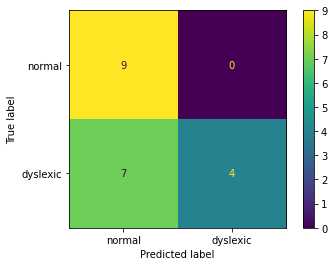

 ari: 0.055  presicion: 0.803  recall:0.650  f1-score: 0.617  auc roc:  0.682  tnr:  0.714 


In [199]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr: .3f} "
)




# A bit of data and participant cleaning


In [200]:

predictions = {}

for subject_id in subject_ids:

    # x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    
    # x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
    
    # grade = list(set(fix_demo_new.loc[fix_demo_new.SubjectID == subject_id].Grade))[0]
    # tmp = fix_demo.loc[fix_demo.Grade == grade] 
    
    # x_test_subj_shuffle = x_test_subj_shuffle.loc[
    # (x_test_subj_shuffle.FIX_X >= tmp.FIX_X.min()) & 
    # (x_test_subj_shuffle.FIX_X <= tmp.FIX_X.max()) &
    # (x_test_subj_shuffle.FIX_Y >= tmp.FIX_Y.min()) & 
    # (x_test_subj_shuffle.FIX_Y <= tmp.FIX_Y.max()) &
    # (x_test_subj_shuffle.FIX_DURATION >= tmp.FIX_DURATION.min()) & 
    # (x_test_subj_shuffle.FIX_DURATION <= tmp.FIX_DURATION.max()) 
    # ]

    
    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr8: 
  X_test (925, 16) Shuffleed (925, 16) Preproccessed (925, 13)  Equal feature space: True 

 Subject_id = nnr26: 
  X_test (567, 16) Shuffleed (567, 16) Preproccessed (567, 13)  Equal feature space: True 

 Subject_id = nnr27: 
  X_test (1128, 16) Shuffleed (1128, 16) Preproccessed (1128, 13)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (1016, 16) Shuffleed (1016, 16) Preproccessed (1016, 13)  Equal feature space: True 

 Subject_id = nnr36: 
  X_test (905, 16) Shuffleed (905, 16) Preproccessed (905, 13)  Equal feature space: True 

 Subject_id = nnr41: 
  X_test (740, 16) Shuffleed (740, 16) Preproccessed (740, 13)  Equal feature space: True 

 Subject_id = nnr45: 
  X_test (515, 16) Shuffleed (515, 16) Preproccessed (515, 13)  Equal feature space: True 

 Subject_id = nnr48: 
  X_test (1452, 16) Shuffleed (1452, 16) Preproccessed (1452, 13)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (995, 16) Shuffleed (995, 16) Preproccessed (995,

In [201]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr8 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr26 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr27 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr33 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr36 being: 
   Normal =  0.004, At-risk =  0.000, Dyslexic =  0.996 >> Assigned label: Dyslexic 

Probability of subject ID nnr41 being: 
   Normal =  0.008, At-risk =  0.007, Dyslexic =  0.985 >> Assigned label: Dyslexic 

Probability of subject ID nnr45 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr48 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Proba

In [215]:
fix_demo_g1 = fix_demo.loc[(fix_demo.Grade == 1) & (fix_demo.Group == 3)]
fix_demo_g1 = fix_demo_g1.loc[:, ["FIX_X", "FIX_Y", "FIX_DURATION"]]

fix_demo_g1.describe()

,FIX_X,FIX_Y,FIX_DURATION
count,6623.000000,6623.000000,6623.000000
mean,632.213061,530.846595,397.511098
std,297.713441,21.003574,322.500537
min,119.100000,480.100000,1.000000
25%,379.700000,518.500000,205.000000
50%,613.700000,533.500000,311.000000
75%,867.400000,545.700000,490.000000
max,1441.000000,574.900000,4148.000000


In [214]:
fix_demo_nnr84 = x_dum_test.loc[x_dum_test.SubjectID == 'nnr84']

fix_demo_nnr84 = fix_demo_nnr84.loc[:, ["FIX_X", "FIX_Y", "FIX_DURATION"]]

fix_demo_nnr84.describe()

,FIX_X,FIX_Y,FIX_DURATION
count,1386.000000,1386.000000,1386.000000
mean,621.978139,545.735354,381.307359
std,318.370449,17.498304,218.536476
min,125.100000,419.600000,22.000000
25%,345.300000,535.500000,231.000000
50%,584.000000,545.900000,335.500000
75%,893.225000,554.800000,475.750000
max,1417.800000,718.700000,2686.000000


**Selection criteria:**

- removing the 3rd grade dyslexics due to their inconsistent distribution (nnr8, nnr26, nnr27 )

- removing nnr 84, female 1st grade dyslexics for the same reason



In [225]:
labels_true_ = labels_true[3:-2]  # removing nnr8, nnr26, nnr27 and the last two
labels_true_ += [labels_true[-1]]  # adding nnr 85 (last one)

labels_pred_ = labels_pred[3:-2]  # removing nnr8, nnr26, nnr27 and the last two
labels_pred_ += [labels_pred[-1]]  # adding nnr 85 (last one)


cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_, 
    y_pred=labels_pred_
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
_, support = np.unique(labels_true_, return_counts=True)
tnr = np.dot(tnr, support)/sum(support)



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true_, labels_pred_,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true_, labels_pred_, average='weighted')
rec = sklearn.metrics.recall_score(labels_true_, labels_pred_, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true_, labels_pred_, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true_, labels_pred_)







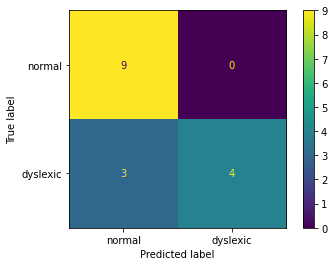

 ari: 0.356  presicion: 0.859  recall:0.812  f1-score: 0.800  auc roc:  0.786  tnr:  0.759 


In [226]:




disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr: .3f} "
)





In [235]:


labels_pred_ 

[0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0]

In [236]:

labels_true_

[2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0]

# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [239]:


labels_true_



[2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0]

In [237]:

dyslexics_idx = np.where(np.asarray(labels_true_) ==2)[0]


dyslexics_idx



array([ 0,  1,  2,  7,  8,  9, 12])

In [238]:

normal_idx = np.asarray(np.where(np.asarray(labels_true_)==0)[0])

normal_idx



array([ 3,  4,  5,  6, 10, 11, 13, 14, 15])

In [240]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



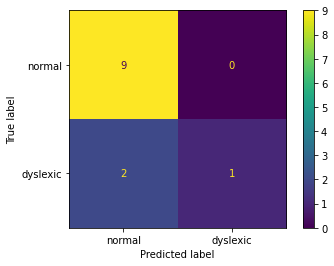

 ari: 0.310  presicion: 0.864  recall:0.833  f1-score: 0.800  auc roc:  0.667  tnr:  0.500 


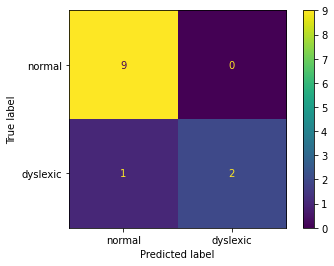

 ari: 0.641  presicion: 0.925  recall:0.917  f1-score: 0.911  auc roc:  0.833  tnr:  0.750 


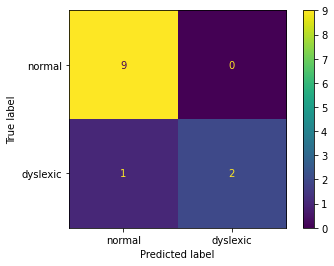

 ari: 0.641  presicion: 0.925  recall:0.917  f1-score: 0.911  auc roc:  0.833  tnr:  0.750 


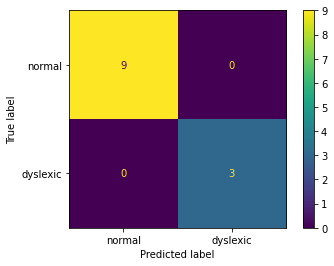

 ari: 1.000  presicion: 1.000  recall:1.000  f1-score: 1.000  auc roc:  1.000  tnr:  1.000 


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


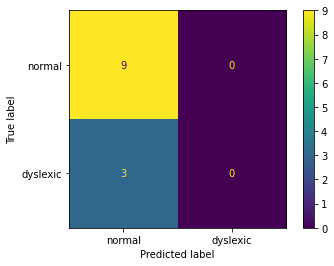

 ari: 0.000  presicion: 0.562  recall:0.750  f1-score: 0.643  auc roc:  0.500  tnr:  0.250 


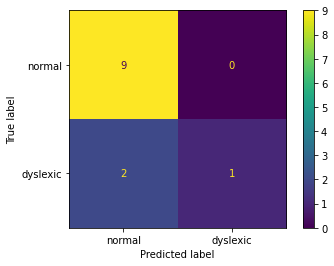

 ari: 0.310  presicion: 0.864  recall:0.833  f1-score: 0.800  auc roc:  0.667  tnr:  0.500 


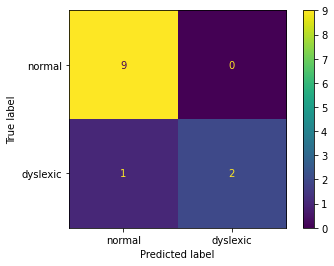

 ari: 0.641  presicion: 0.925  recall:0.917  f1-score: 0.911  auc roc:  0.833  tnr:  0.750 


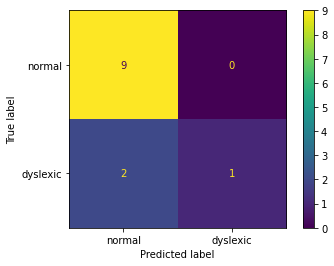

 ari: 0.310  presicion: 0.864  recall:0.833  f1-score: 0.800  auc roc:  0.667  tnr:  0.500 


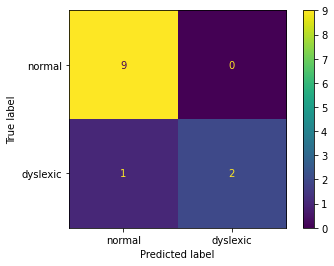

 ari: 0.641  presicion: 0.925  recall:0.917  f1-score: 0.911  auc roc:  0.833  tnr:  0.750 


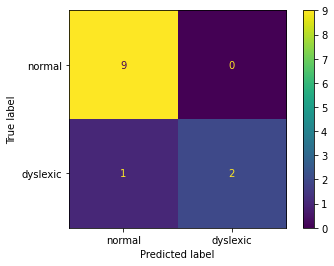

 ari: 0.641  presicion: 0.925  recall:0.917  f1-score: 0.911  auc roc:  0.833  tnr:  0.750 


In [244]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred__sampled = [labels_pred_[i] for i in idx]
    labels_pred__prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true__sampled = [labels_true_[i] for i in idx]
    
    labels_true__sampled_ = enc.fit_transform(np.asarray(labels_true__sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true__sampled, 
    y_pred=labels_pred__sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true__sampled, return_counts=True)
    tnr = np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true__sampled, 
        y_score=labels_pred__sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true__sampled, labels_pred__sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true__sampled, labels_pred__sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true__sampled, labels_pred__sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true__sampled, labels_pred__sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
    if r % 1 == 0:
        
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["normal", "dyslexic"]
                             )



        disp.plot()
        plt.show()

        print(
            f" ari: {ari:.3f} "
            f" presicion: {pre:.3f} "
            f" recall:{rec:.3f} "
            f" f1-score: {fsc:.3f} "
            f" auc roc: {auc_roc: .3f} "
            f" tnr: {tnr: .3f} "
        )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [245]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




 ari: 0.514 ± 0.266 
 presicion: 0.878 ± 0.112 
 recall: 0.883 ± 0.067 
 f1-score: 0.860 ± 0.095 
 auc roc:  0.767 ±  0.133 
 tnr:  0.650 ±  0.200 



# Feature importance 

In [317]:


selected_x_test_subjects_ID = [
    "m57", "s30", "s34", "s46",  # G1NF, G1NM, G1DF, G1DM,
    "s101", "m24", "m4", "s22",  # G2*
    "m5", "m70", "s133", "m88",  # G3*
    "m84", "m48", "m43", "kad08",  # G4*
    "s124", "s49", "m14", "s166",  # G5*
    "s163", # G6RF
]

selected_x_test_subjects_ID

['m57',
 's30',
 's34',
 's46',
 's101',
 'm24',
 'm4',
 's22',
 'm5',
 'm70',
 's133',
 'm88',
 'm84',
 'm48',
 'm43',
 'kad08',
 's124',
 's49',
 'm14',
 's166',
 's163']

In [318]:


fix_demo_shape = []

for s in selected_x_test_subjects_ID:
    fix_demo_shape.append(fix_demo.loc[fix_demo.SubjectID == s])
    
fix_demo_shape = pd.concat(fix_demo_shape)    


In [319]:


x_train.shape



(225350, 13)

In [320]:


x_fix_demo_shape, y_fix_demo_shape = dd.get_onehot_features_targets(
    data=fix_demo_shape,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [321]:

x_test_shap = preprocess_data(x=x_fix_demo_shape, pp="mm")  # only x is standardized

y_test_shape = y_fix_demo_shape.Group.values



pre-processing: mm
Preprocessed data shape: (17549, 13)


In [322]:
y_test_shape.shape

(17549,)

In [323]:


explainer = shap.Explainer(mdl.predict, x_test_shap, feature_names=list(x_org.columns))



In [324]:


shap_values = explainer(x_test_shap)



Permutation explainer:  81%|██████████████████████████████████████████████████████████████████████████████████████████▎                     | 14145/17549 [16:12<03:56, 14.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [325]:

print("Shap values are determined!")




Shap values are determined!


In [326]:




y_test.shape, x_test.shape, shap_values.values.shape





((2000,), (2000, 13), (17549, 13))

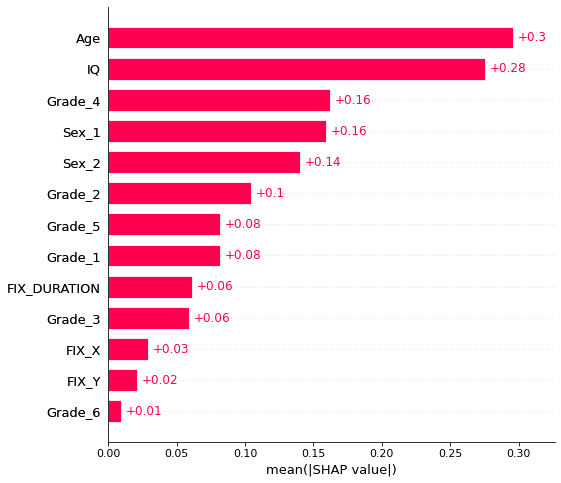

In [327]:


shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




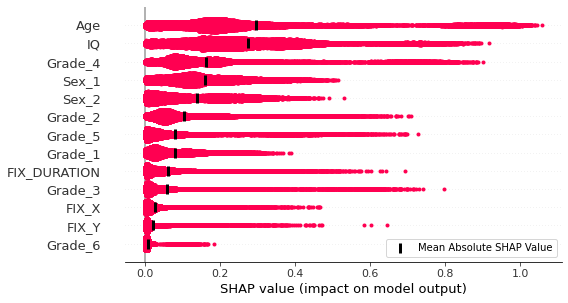

In [328]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")






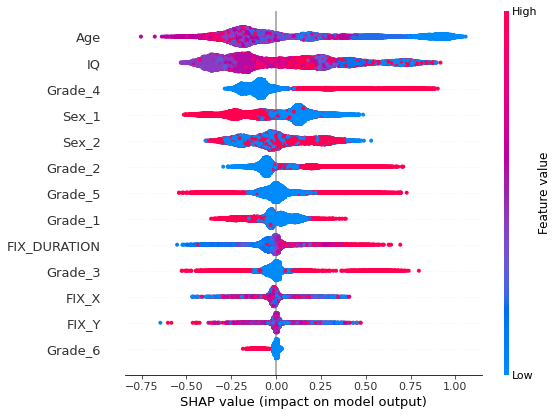

In [330]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test_shap,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )





FixedFormatter should only be used together with FixedLocator


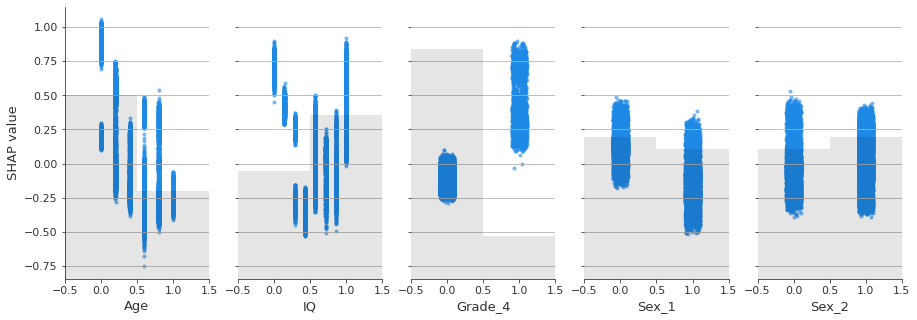

In [331]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")





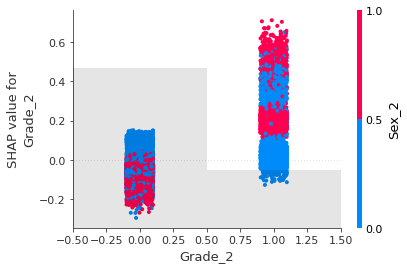

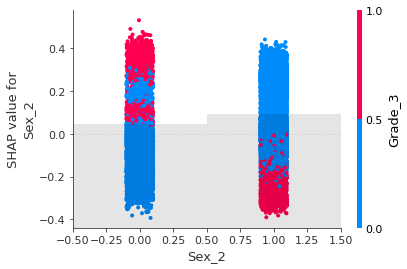

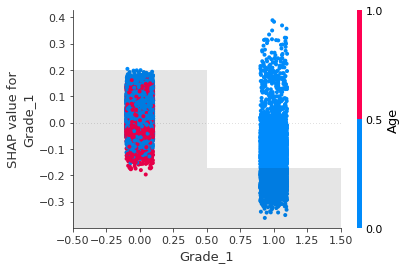

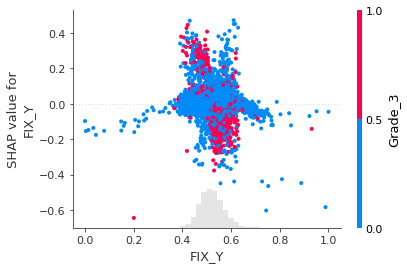

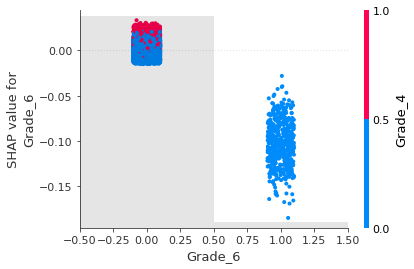

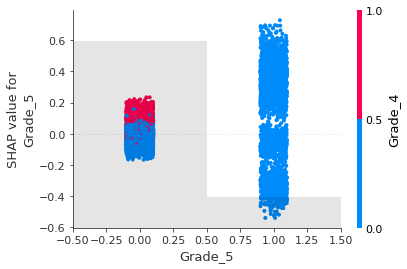

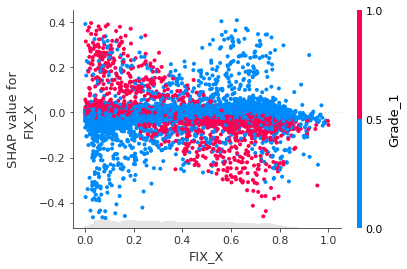

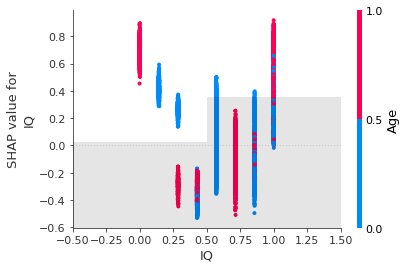

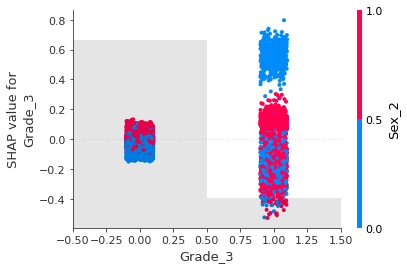

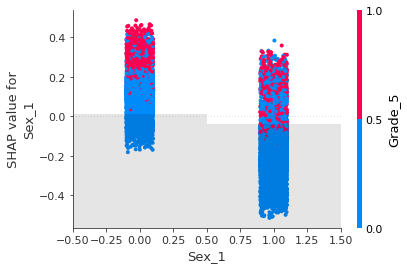

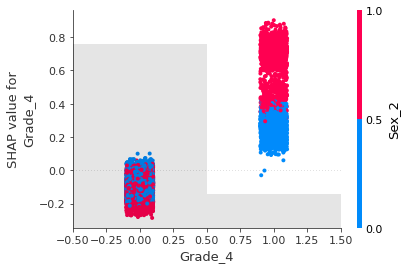

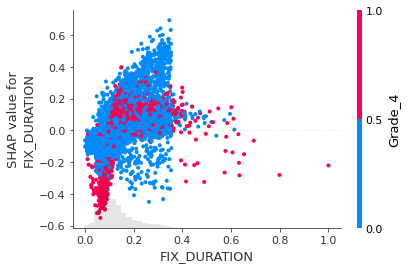

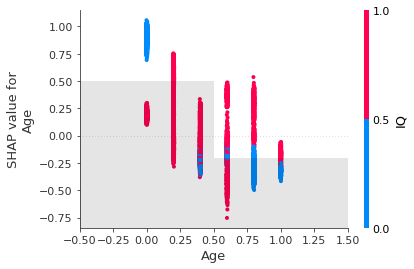

In [332]:


for i in range(x_test_shap.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)





# SHAP for entire data

In [333]:


explainer = shap.Explainer(mdl.predict, x_train, feature_names=list(x_org.columns))



In [ ]:


shap_values_train = explainer(x_train)



Permutation explainer:   2%|██▎                                                                                                           | 4638/225350 [05:24<4:19:08, 14.19it/s]

In [342]:

print("Shap values are determined!")




Shap values are determined!


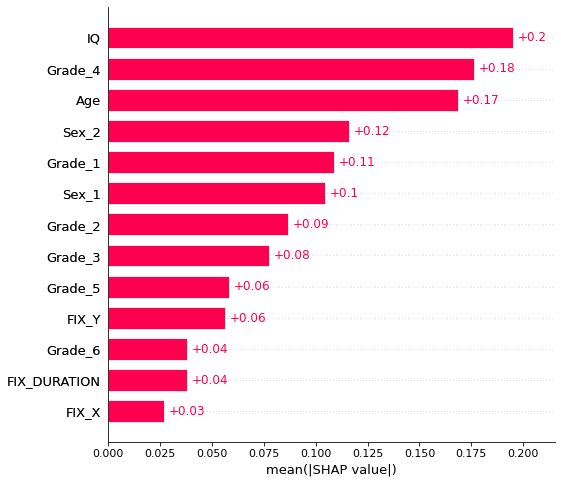

In [343]:


shap.plots.bar(shap_values_train, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


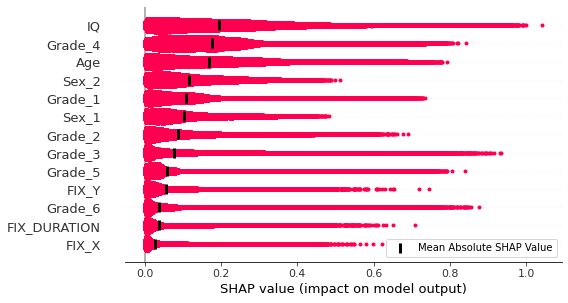

In [344]:


plt.gcf()
shap.plots.bar(shap_values_train.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values_train.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values_train.values[:, col_ind]))
    masv[name] = mean_abs_sv
    
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")






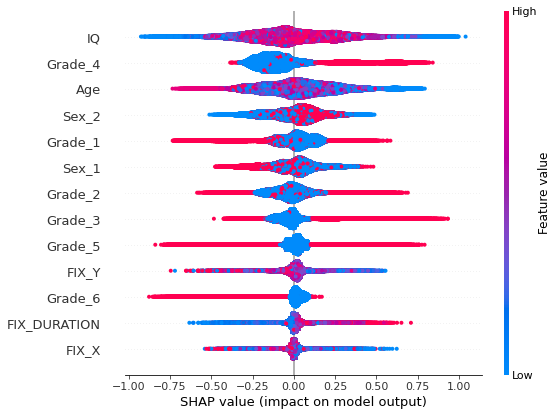

In [345]:


shap.summary_plot(shap_values=shap_values_train.values, 
                  features=x_train,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )





FixedFormatter should only be used together with FixedLocator


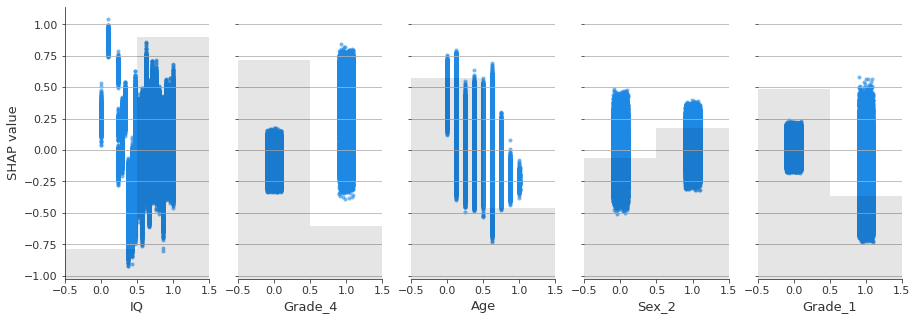

In [346]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values_train[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")





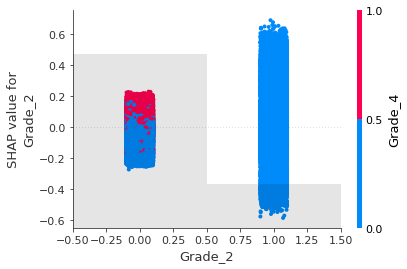

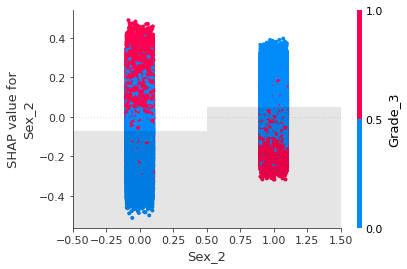

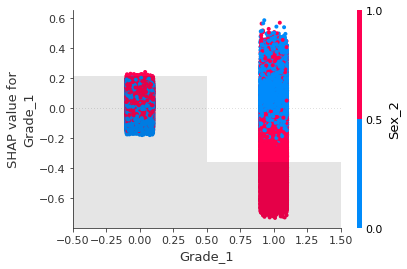

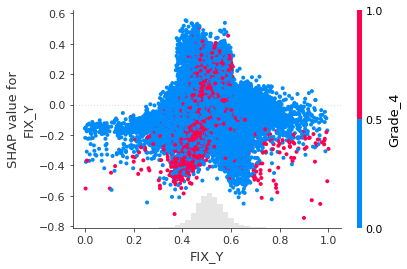

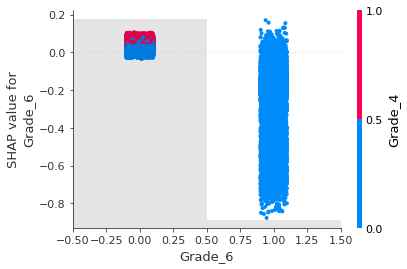

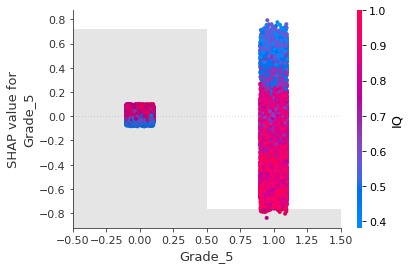

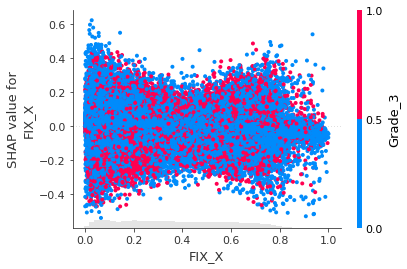

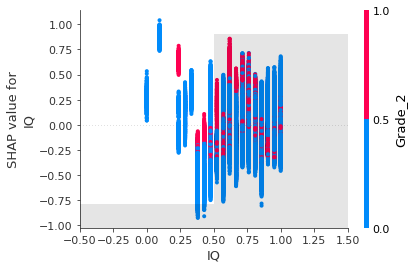

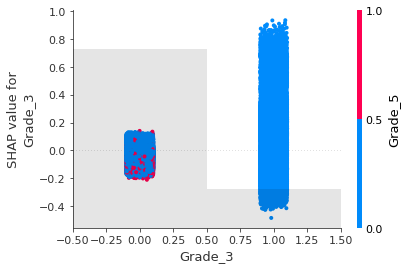

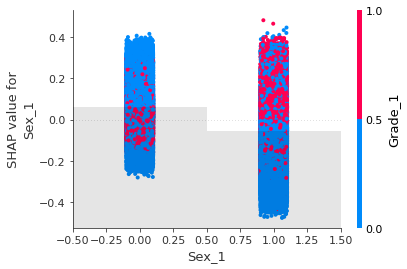

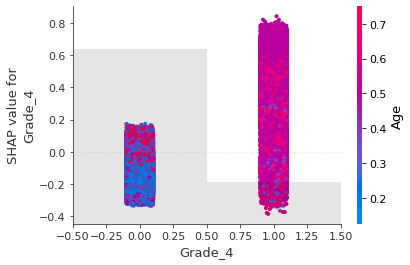

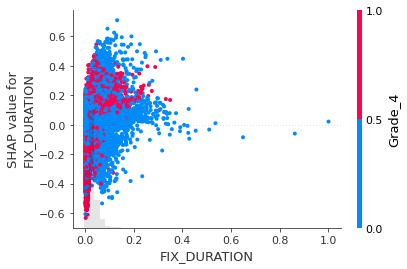

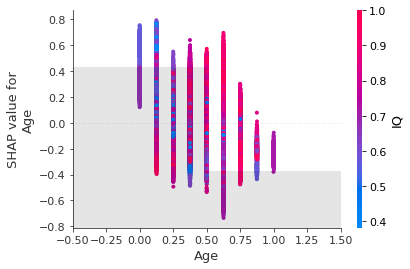

In [347]:


for i in range(x_train.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values_train[:, i], color=shap_values_train, ax=ax)



